<a href="https://colab.research.google.com/github/tyfmanlapaz/Data-Science/blob/main/Final_Bike_Sharing_Regression_with_RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bike Sharing Dataset (Evaluating the efficacy of RNN, LSTM and GRU models for time series prediction)**

Dataset Source: Kaggle - https://www.kaggle.com/datasets/marklvl/bike-sharing-dataset

# **Section 1: Data Collection**


In [ ]:
#--------------------------------------------------------------------------------------#
# 1.1 Import Libraries
#--------------------------------------------------------------------------------------#
# Importing libraries and configure env display settings
import os
import random
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns

# ML and DL libs
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import RNN, SimpleRNN, LSTM, GRU
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras.backend as K
import tensorflow as tf

# for Hyperparameter tuning
from keras.regularizers import l1, l2, l1_l2


# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

pd.reset_option('display.max_columns')
pd.options.display.width = 170

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
# define configs
class CONFIG:
    #data_folder = '../input/tsdata-1/'
    EPOCHS = 150
    SEED = 42
    BATCH_SIZE = 16
    init_learn_rate = 0.001
    init_unit_size = 50

In [ ]:
# define seeds for reproducibility
from numpy.random import seed

os.environ['PYTHONHASHSEED']=str(CONFIG.SEED) # 1. Set the `PYTHONHASHSEED` for hash based operations in python
random.seed(CONFIG.SEED)                      # 2. Set the `python` built-in pseudo-random generator at a fixed value
np.random.seed(CONFIG.SEED)                   # 3. Set the `numpy` pseudo-random generator at global level
os.environ['TF_DETERMINISTIC_OPS'] = '1'      # Set seed for TF operations
tf.random.set_seed(CONFIG.SEED)

In [ ]:
#--------------------------------------------------------------------------------------#
# 1.2 Authenticating and Mounting the Dataset
#--------------------------------------------------------------------------------------#
from google.colab import drive
import shutil

# authenticating and mounting GDrive
drive.mount('/content/drive')

# defining path to dataset
dataset_path = '/content/drive/My Drive/GoogleColab/Datasets'
dataset_folder = 'bike-sharing-dataset'

# define target and source dir
drive_directory = os.path.join(dataset_path, dataset_folder)
colab_directory = '/content/datasets'

#create directory and copy files from drive.
if not os.path.exists(colab_directory):
  # if not existing create it.
  os.makedirs(drive_directory, exist_ok=True)
  shutil.copytree(drive_directory, colab_directory)
  print("Directory and Files copied successfully...")
else: print("Directory and Files already loaded...")


Mounted at /content/drive
Directory and Files copied successfully...


In [ ]:
#--------------------------------------------------------------------------------------#
# Function load and save datasets
#--------------------------------------------------------------------------------------#
def read_save_data(directory, filename, operation, bike_df=pd.DataFrame()):
    bike_data = []  # an array to store dataframes

    # Get a list of all CSV files from directory
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    # for read operations
    if operation == "read":
      # iterate over the files
      for file in csv_files:
          file_path = os.path.join(directory, file)     # define file path
          bike_df = pd.read_csv(file_path)         # read file to dataframe
          bike_data.append(bike_df)                 # append dataframes to the array
          print(f"File {file} loaded to dataframe successfully...")

    # for save operations
    elif operation == "save":
          bike_df.to_csv(f'{directory}/{filename}', index=False) # save dataframe to file
          print(f"File {filename} saved to file successfully...")

    return bike_data

In [ ]:
#--------------------------------------------------------------------------------------#
# call function to load datasets
#--------------------------------------------------------------------------------------#
bike_daily_df, bike_hourly_df = read_save_data(colab_directory, '', 'read')

File day.csv loaded to dataframe successfully...
File hour.csv loaded to dataframe successfully...


# **Section 2: Exploratory Data Analysis**

In [ ]:
#--------------------------------------------------------------------------------------#
# Get first five rows of each dataset
#--------------------------------------------------------------------------------------#
print(f'First Five Rows of "Daily" dataset \n\n {bike_daily_df.head()}\n')
print(f'First Five Rows of "Hourly" dataset \n\n {bike_hourly_df.head()}\n')

First Five Rows of "Daily" dataset 

    instant      dteday  season  yr  mnth  holiday  weekday  workingday  weathersit      temp     atemp       hum  windspeed  casual  registered   cnt
0        1  2011-01-01       1   0     1        0        6           0           2  0.344167  0.363625  0.805833   0.160446     331         654   985
1        2  2011-01-02       1   0     1        0        0           0           2  0.363478  0.353739  0.696087   0.248539     131         670   801
2        3  2011-01-03       1   0     1        0        1           1           1  0.196364  0.189405  0.437273   0.248309     120        1229  1349
3        4  2011-01-04       1   0     1        0        2           1           1  0.200000  0.212122  0.590435   0.160296     108        1454  1562
4        5  2011-01-05       1   0     1        0        3           1           1  0.226957  0.229270  0.436957   0.186900      82        1518  1600

First Five Rows of "Hourly" dataset 

    instant      dteday

In [ ]:
#--------------------------------------------------------------------------------------#
# examine the dimension of the datasets (row count, column count)
#--------------------------------------------------------------------------------------#
print(f'bike_daily_df: rows = {bike_daily_df.shape[0]}, columns = {bike_daily_df.shape[1]}')
print(f'bike_hourly_df: rows = {bike_hourly_df.shape[0]}, columns = {bike_hourly_df.shape[1]}\n')

#--------------------------------------------------------------------------------------#
# examine column data types
#--------------------------------------------------------------------------------------#
print(bike_daily_df.info())
# We will use the daily dataset from hereon

bike_daily_df: rows = 731, columns = 16
bike_hourly_df: rows = 17379, columns = 17

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
None


In [ ]:
#--------------------------------------------------------------------------------------#
# Check if 'Daily' dataset has missing values
#--------------------------------------------------------------------------------------#
print(f'Number of Rows with Null Values:')
print(bike_daily_df.isnull().sum())
# Note: Daily Dataset has no missing values

Number of Rows with Null Values:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [ ]:
#--------------------------------------------------------------------------------------#
# Get Statistical Summary
#--------------------------------------------------------------------------------------#
# Statistical summary of numeric variables
bike_daily_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


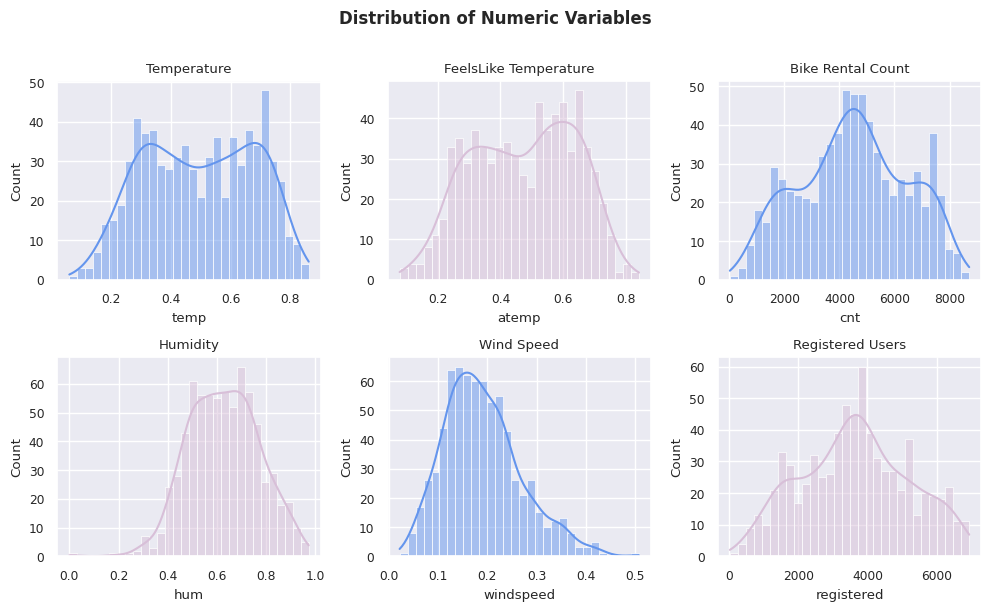

In [ ]:
#--------------------------------------------------------------------------------------#
# Plotting distributions of key numeric variables
#--------------------------------------------------------------------------------------#
sns.set(font_scale=0.8)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
fig.suptitle('Distribution of Numeric Variables', fontsize=12, fontweight='bold', y=1.01)

sns.histplot(bike_daily_df['temp'], bins=30, kde=True, ax=axes[0, 0], color='cornflowerblue')
axes[0, 0].set_title('Temperature')

sns.histplot(bike_daily_df['atemp'], bins=30, kde=True, ax=axes[0, 1], color='thistle')
axes[0, 1].set_title('FeelsLike Temperature')

sns.histplot(bike_daily_df['cnt'], bins=30, kde=True, ax=axes[0, 2], color='cornflowerblue')
axes[0, 2].set_title('Bike Rental Count')

sns.histplot(bike_daily_df['hum'], bins=30, kde=True, ax=axes[1, 0], color='thistle')
axes[1, 0].set_title('Humidity')

sns.histplot(bike_daily_df['windspeed'], bins=30, kde=True, ax=axes[1, 1], color='cornflowerblue')
axes[1, 1].set_title('Wind Speed')

sns.histplot(bike_daily_df['registered'], bins=30, kde=True, ax=axes[1, 2], color='thistle')
axes[1, 2].set_title('Registered Users')

plt.tight_layout()
plt.show()

# Observation: Except for the target variable (cnt) and registered/casual, the numeric variables are normalized

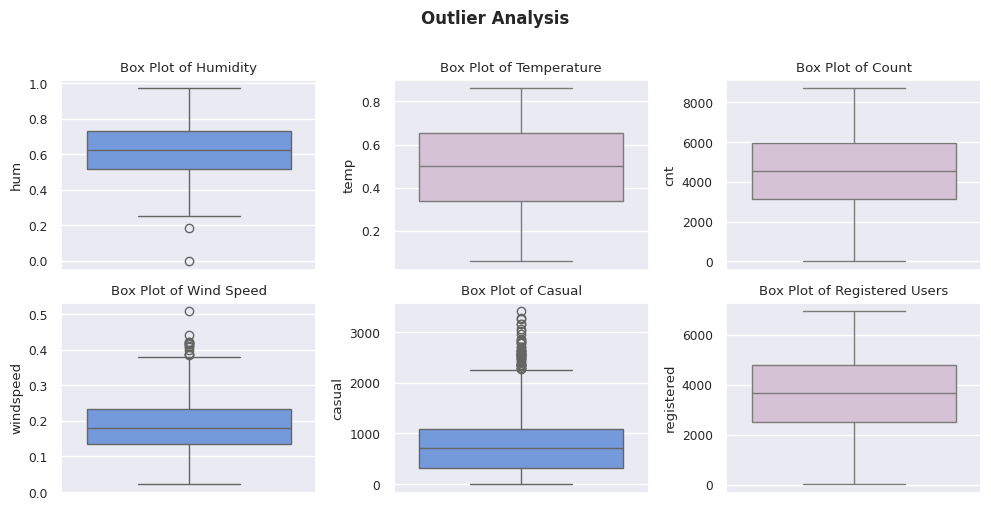

In [ ]:
#--------------------------------------------------------------------------------------#
#Plot numerical features for Outlier Analysis
#--------------------------------------------------------------------------------------#
def plot_boxplots_outliers(dataset):
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
  fig.suptitle('Outlier Analysis', fontsize=12, fontweight='bold', y=1.01)

  sns.boxplot(data=dataset,y="hum",orient="v",ax=axes[0][0], color='cornflowerblue')   #plot hum
  axes[0][0].set(title="Box Plot of Humidity")
  sns.boxplot(data=dataset,y="temp",orient="v",ax=axes[0][1], color='thistle')   #plot temp
  axes[0][1].set(title="Box Plot of Temperature")
  sns.boxplot(data=dataset,y="cnt",orient="v",ax=axes[0][2], color='thistle')   #plot cnt
  axes[0][2].set(title="Box Plot of Count")
  sns.boxplot(data=dataset,y="windspeed",orient="v",ax=axes[1][0], color='cornflowerblue')   #plot windspeed
  axes[1][0].set(title="Box Plot of Wind Speed")
  sns.boxplot(data=dataset,y="casual",orient="v",ax=axes[1][1], color='cornflowerblue')   #plot casual
  axes[1][1].set(title="Box Plot of Casual")
  sns.boxplot(data=dataset,y="registered",orient="v",ax=axes[1][2], color='thistle')   #plot registered
  axes[1][2].set(title="Box Plot of Registered Users")
  plt.tight_layout()
  plt.show()

plot_boxplots_outliers(bike_daily_df)  # call function to plot the outliers

Note: That hum, windspeed, and registered have outliers so we will treat this for better model generalization.

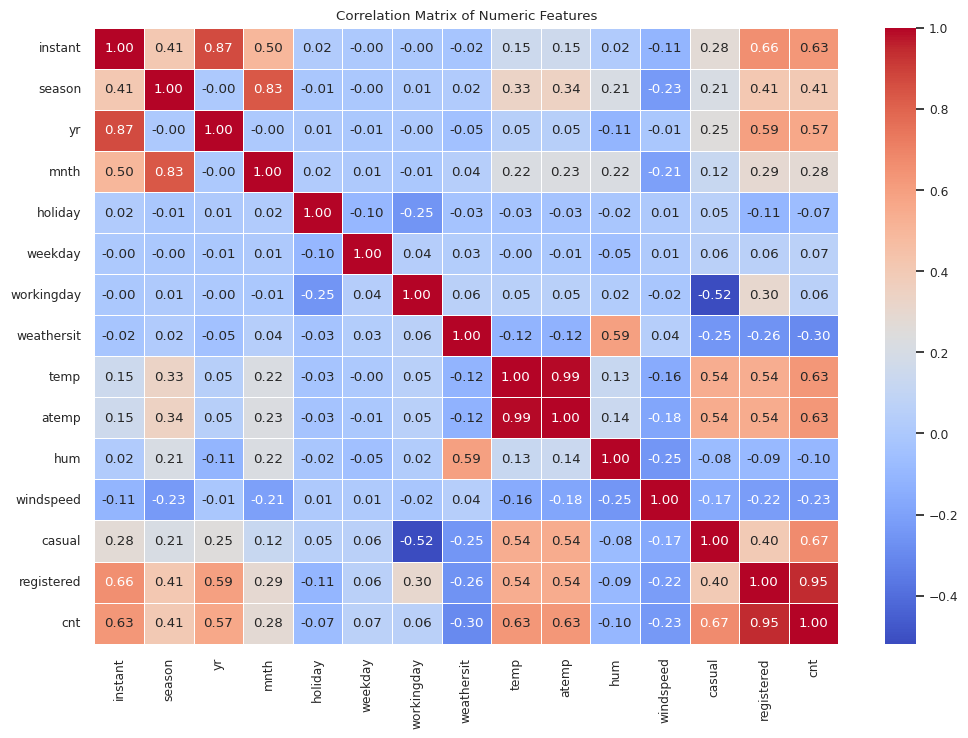

In [ ]:
#--------------------------------------------------------------------------------------#
# Correlation Matrix
#--------------------------------------------------------------------------------------#
numeric_columns = bike_daily_df.select_dtypes(include=[np.number]).columns

# Correlation matrix
correlation_matrix = bike_daily_df[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

**Note:**

*   season has very high correlation with mnth
*   atemp has very high correlation with temp
*  registered and casual also has very high correlation with cnt, this is expected as cnt is the sum of both rentals from both users

This are candidates for removal during preprocessing

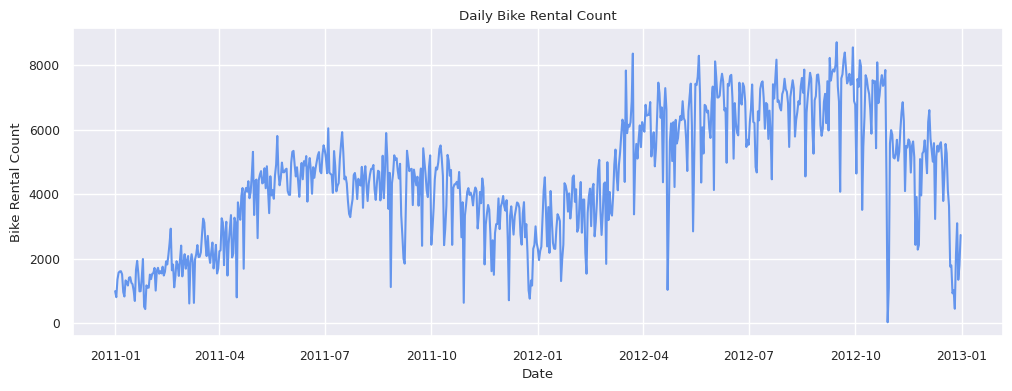

In [ ]:
#--------------------------------------------------------------------------------------#
# Plot Daily Bike Rental Count
#--------------------------------------------------------------------------------------#
# Convert dteday to datetime and set as index
bike_daily_df['dteday'] = pd.to_datetime(bike_daily_df['dteday']) #convert to datetime
bike_daily_df['datetime'] = bike_daily_df['dteday']               #copy dteday values to datetime
bike_daily_df.set_index('dteday', inplace=True)                   #set dteday as index for plotting purposes later

# Plot the data
plt.figure(figsize=(12, 4))
sns.lineplot(data=bike_daily_df, x='dteday', y='cnt', color='cornflowerblue')

# Add a title and labels
plt.title('Daily Bike Rental Count')
plt.xlabel('Date')
plt.ylabel('Bike Rental Count')

# Show the plot
plt.show()

In [ ]:
bike_daily_df.info()    #dteday is now the index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   season      731 non-null    int64         
 2   yr          731 non-null    int64         
 3   mnth        731 non-null    int64         
 4   holiday     731 non-null    int64         
 5   weekday     731 non-null    int64         
 6   workingday  731 non-null    int64         
 7   weathersit  731 non-null    int64         
 8   temp        731 non-null    float64       
 9   atemp       731 non-null    float64       
 10  hum         731 non-null    float64       
 11  windspeed   731 non-null    float64       
 12  casual      731 non-null    int64         
 13  registered  731 non-null    int64         
 14  cnt         731 non-null    int64         
 15  datetime    731 non-null    datetime64[ns]
dtypes: date

# Section 3: Data Preprocessing

In [ ]:
# Function to treat outliers by capping the values to its IQR ranges
def cap_outliers(dataset, var='hum'):
  # Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
  Q1 = dataset[var].quantile(0.25)
  Q3 = dataset[var].quantile(0.75)

  # Step 2: Calculate IQR
  IQR = Q3 - Q1

  # Step 3: Define bounds for detecting outliers
  if var == 'casual':
    lower_bound = int(Q1 - (1.5 * IQR))
    upper_bound = int(Q3 + (1.5 * IQR))
  else:
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

  # Step 4: Count outlier observations
  lower_bound_count = (dataset[var] < lower_bound).sum()
  upper_bound_count = (dataset[var] > upper_bound).sum()
  total_outliers = ((dataset[var] < lower_bound) | (dataset[var] > upper_bound)).sum()

  # Step 5: Replace values > upper_bound with upper_bound and < lower_bound with lower_bound
  dataset[var] = np.where(
      dataset[var] > upper_bound,       # First condition: Check if values are greater than upper_bound
      upper_bound,                        # Values to use if the first condition is True
      np.where(
          dataset[var] < lower_bound,   # Second condition: Check if values are less than lower_bound
          lower_bound,                    # Values to use if the second condition is True
          dataset[var]                  # Values to use if both conditions are False
      ))

  # Output the results
  print('Outlier Treatment by Capping Lower and Upper Bounds')
  print(f'+' * 60)
  print(f"Feature Name: {var}, Total Outliers: {total_outliers}")
  print(f"Lower Bound: {lower_bound}, Count Below Lower Bound: {lower_bound_count}")
  print(f"Upper Bound: {upper_bound}, Count Above Upper Bound: {upper_bound_count} \n")

Outlier Treatment by Capping Lower and Upper Bounds
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Feature Name: hum, Total Outliers: 2
Lower Bound: 0.20468725, Count Below Lower Bound: 2
Upper Bound: 1.0455212500000002, Count Above Upper Bound: 0 

Outlier Treatment by Capping Lower and Upper Bounds
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Feature Name: windspeed, Total Outliers: 13
Lower Bound: -0.012446750000000034, Count Below Lower Bound: 0
Upper Bound: 0.38061125, Count Above Upper Bound: 13 

Outlier Treatment by Capping Lower and Upper Bounds
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Feature Name: casual, Total Outliers: 44
Lower Bound: -855, Count Below Lower Bound: 0
Upper Bound: 2266, Count Above Upper Bound: 44 



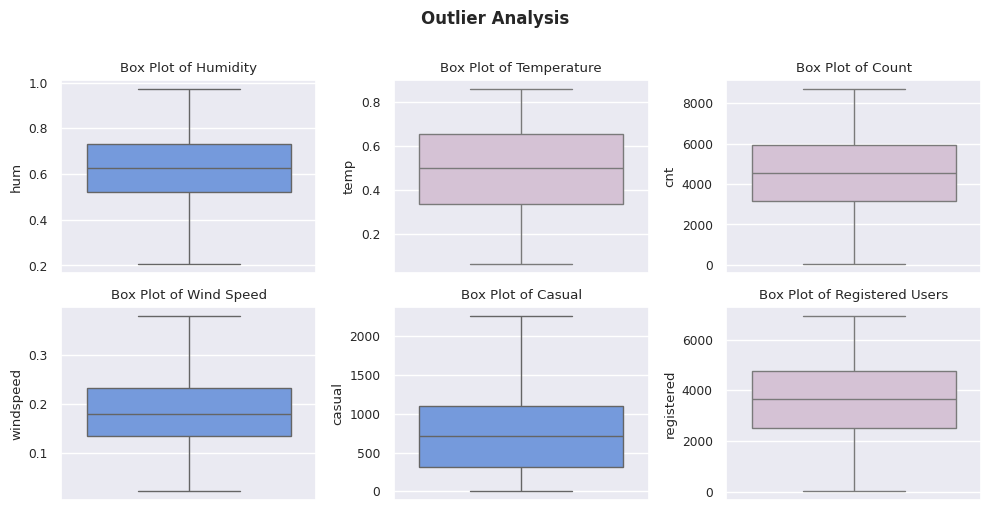

In [ ]:
#--------------------------------------------------------------------------------------#
# Outlier Treatment
#--------------------------------------------------------------------------------------#
# call custom function to cap outliers
cap_outliers(bike_daily_df,'hum')
cap_outliers(bike_daily_df,'windspeed')
cap_outliers(bike_daily_df,'casual')

# call function to plot the outliers, check if no outliers exists after capping
plot_boxplots_outliers(bike_daily_df)

In [ ]:
#--------------------------------------------------------------------------------------#
# Treating Anomalies on Rental Count
#--------------------------------------------------------------------------------------#
# This date is an outlier/extraordinary due the hurricane in the area.
# This would introduce noise to the network if not treated.
# So we get the mean of for the month 10, and assign it to the 29th and 30th.

min_cnt_row = bike_daily_df[bike_daily_df['cnt'] == bike_daily_df['cnt'].min()]  # Find the row with the lowest "cnt" value
min_cnt_date = min_cnt_row['datetime'].iloc[0]
print(f"The date with the lowest 'cnt' value is {min_cnt_date}")  # Extract the "dteday" from this row

extraordinary_df = bike_daily_df[(bike_daily_df.yr == 1) & (bike_daily_df.mnth == 10)]
average_count = round(extraordinary_df.cnt.mean())
print(f"Average Bike Rental Count for 2012-10: {average_count}")

bike_daily_df.loc['2012-10-29', 'cnt'] = average_count
bike_daily_df.loc['2012-10-30', 'cnt'] = average_count

The date with the lowest 'cnt' value is 2012-10-29 00:00:00
Average Bike Rental Count for 2012-10: 6414


In [ ]:
min_cnt_row   #print row with min cnt

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
dteday,,,,,,,,,,,,,,,,
2012-10-29,668,4,1,10,0,1,1,3,0.44,0.4394,0.88,0.3582,2,20,22,2012-10-29


In [ ]:
bike_daily_df.iloc[667:].head() #review treated rows

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
dteday,,,,,,,,,,,,,,,,
2012-10-29,668,4,1,10,0,1,1,3,0.440000,0.439400,0.880000,0.358200,2,20,6414,2012-10-29
2012-10-30,669,4,1,10,0,2,1,2,0.318182,0.309909,0.825455,0.213009,87,1009,6414,2012-10-30
2012-10-31,670,4,1,10,0,3,1,2,0.357500,0.361100,0.666667,0.166667,419,5147,5566,2012-10-31
2012-11-01,671,4,1,11,0,4,1,2,0.365833,0.369942,0.581667,0.157346,466,5520,5986,2012-11-01
2012-11-02,672,4,1,11,0,5,1,1,0.355000,0.356042,0.522083,0.266175,618,5229,5847,2012-11-02


In [ ]:
#--------------------------------------------------------------------------------------#
# Renaming columns names to more readable names
#--------------------------------------------------------------------------------------#
bike_daily_clean = bike_daily_df.copy()  # create copy for preprocessed data
bike_daily_clean.rename(columns={
                        #'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'yr':'year'},inplace=True)

bike_daily_clean.head()

,instant,season,year,month,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count,datetime
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011-01-01
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011-01-02
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011-01-03
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,2011-01-04
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2011-01-05


**Feature Engineering**

In [ ]:
#--------------------------------------------------------------------------------------#
# Encoding Cyclical Features
#--------------------------------------------------------------------------------------#
def cyclical_encoding(df, column, max):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max)
    return df

# cyclical encoding for month and weekday, instead of one hot encoding
bike_daily_clean = cyclical_encoding(bike_daily_clean, 'month', 12)
bike_daily_clean = cyclical_encoding(bike_daily_clean, 'weekday', 7)
bike_daily_clean.sample(5)

,instant,season,year,month,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count,datetime,month_sin,month_cos,weekday_sin,weekday_cos
dteday,,,,,,,,,,,,,,,,,,,,
2012-12-04,704,4,1,12,0,2,1,1,0.475833,0.469054,0.733750,0.174129,551,6055,6606,2012-12-04,-2.449294e-16,1.000000e+00,0.974928,-0.222521
2011-02-03,34,1,0,2,0,4,1,1,0.186957,0.177878,0.437826,0.277752,61,1489,1550,2011-02-03,8.660254e-01,5.000000e-01,-0.433884,-0.900969
2011-10-28,301,4,0,10,0,5,1,2,0.330833,0.318812,0.585833,0.229479,456,3291,3747,2011-10-28,-8.660254e-01,5.000000e-01,-0.974928,-0.222521
2012-04-01,457,2,1,4,0,0,0,2,0.425833,0.417287,0.676250,0.172267,2266,3694,6041,2012-04-01,8.660254e-01,-5.000000e-01,0.000000,1.000000
2012-09-25,634,4,1,9,0,2,1,1,0.550000,0.544179,0.570000,0.236321,845,6693,7538,2012-09-25,-1.000000e+00,-1.836970e-16,0.974928,-0.222521


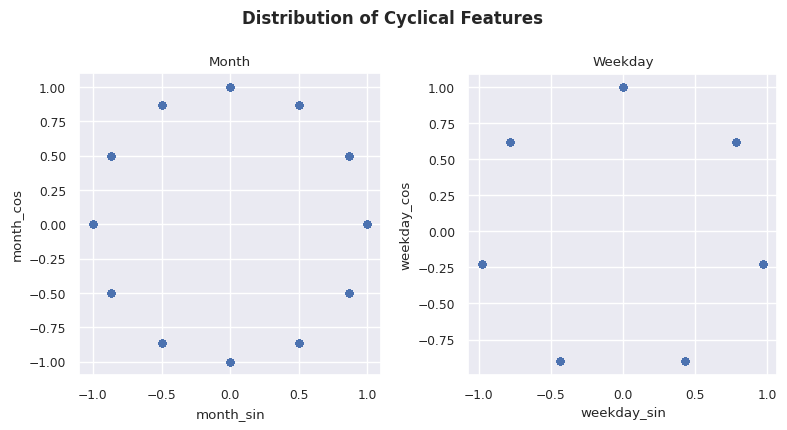

In [ ]:
#--------------------------------------------------------------------------------------#
# Plot Distribution of Cyclical Features
#--------------------------------------------------------------------------------------#
def plot_cyclical_features():
  # Create a figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.figure.set_size_inches(8, 4)

  fig.suptitle('Distribution of Cyclical Features', fontsize=12, fontweight='bold', y=1.03)

  # Plot month_sin vs month_cos on the first subplot
  bike_daily_clean.plot.scatter('month_sin', 'month_cos', ax=ax1).set_aspect('equal')

  # Plot weekday vs cnt on the second subplot
  bike_daily_clean.plot.scatter('weekday_sin','weekday_cos', ax=ax2).set_aspect('equal')

  # Set the titles for the subplots
  ax1.set_title('Month')
  ax2.set_title('Weekday')

  # Show the plot
  plt.tight_layout()
  plt.show()

plot_cyclical_features()

**Note:** The cyclical features have ranges between -1 to 1 which is different from the rest. We will need to normalize this together with the count variable.

In [ ]:
#--------------------------------------------------------------------------------------#
# One Hot Encode Categorical Features
#--------------------------------------------------------------------------------------#
#bike_daily_clean = pd.get_dummies(bike_daily_clean, columns=['weather_condition'], prefix='weather_condition', dtype='int')
bike_daily_clean = pd.get_dummies(bike_daily_clean, columns=['season'], prefix='season', dtype='int')

print(bike_daily_clean.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   instant            731 non-null    int64         
 1   year               731 non-null    int64         
 2   month              731 non-null    int64         
 3   is_holiday         731 non-null    int64         
 4   weekday            731 non-null    int64         
 5   is_workingday      731 non-null    int64         
 6   weather_condition  731 non-null    int64         
 7   temp               731 non-null    float64       
 8   atemp              731 non-null    float64       
 9   humidity           731 non-null    float64       
 10  windspeed          731 non-null    float64       
 11  casual             731 non-null    int64         
 12  registered         731 non-null    int64         
 13  total_count        731 non-null    int64      

In [ ]:
#--------------------------------------------------------------------------------------#
# Create New Features:  Proportion of Casual and Registered against Count
#--------------------------------------------------------------------------------------#
#bike_daily_clean['casual_rate'] = bike_daily_clean['casual'] / bike_daily_clean['total_count']
#bike_daily_clean['registered_rate'] = bike_daily_clean['registered'] / bike_daily_clean['total_count']

In [ ]:
#--------------------------------------------------------------------------------------#
# Normalizing Variables
#--------------------------------------------------------------------------------------#
# Initialize separate scalers for each feature
scaler_count = MinMaxScaler(feature_range=(0, 1))
scaler_month_sin = MinMaxScaler(feature_range=(0, 1))
scaler_month_cos = MinMaxScaler(feature_range=(0, 1))
scaler_weekday_sin = MinMaxScaler(feature_range=(0, 1))
scaler_weekday_cos = MinMaxScaler(feature_range=(0, 1))

# Apply fit_transform to each feature independently
bike_daily_clean['month_sin_scaled'] = scaler_month_sin.fit_transform(bike_daily_clean['month_sin'].values.reshape(-1, 1))
bike_daily_clean['month_cos_scaled'] = scaler_month_cos.fit_transform(bike_daily_clean['month_cos'].values.reshape(-1, 1))
bike_daily_clean['weekday_sin_scaled'] = scaler_weekday_sin.fit_transform(bike_daily_clean['weekday_sin'].values.reshape(-1, 1))
bike_daily_clean['weekday_cos_scaled'] = scaler_weekday_cos.fit_transform(bike_daily_clean['weekday_cos'].values.reshape(-1, 1))
bike_daily_clean['count_scaled'] = scaler_count.fit_transform(bike_daily_clean['total_count'].values.reshape(-1, 1))

#normalize_data()  # call function to normalize data
bike_daily_clean.head()

,instant,year,month,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,...,weekday_cos,season_1,season_2,season_3,season_4,month_sin_scaled,month_cos_scaled,weekday_sin_scaled,weekday_cos_scaled,count_scaled
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,...,0.623490,1,0,0,0,0.75,0.933013,0.099031,8.019377e-01,0.066884
2011-01-02,2,0,1,0,0,0,2,0.363478,0.353739,0.696087,...,1.000000,1,0,0,0,0.75,0.933013,0.500000,1.000000e+00,0.044670
2011-01-03,3,0,1,0,1,1,1,0.196364,0.189405,0.437273,...,0.623490,1,0,0,0,0.75,0.933013,0.900969,8.019377e-01,0.110829
2011-01-04,4,0,1,0,2,1,1,0.200000,0.212122,0.590435,...,-0.222521,1,0,0,0,0.75,0.933013,1.000000,3.568959e-01,0.136545
2011-01-05,5,0,1,0,3,1,1,0.226957,0.229270,0.436957,...,-0.900969,1,0,0,0,0.75,0.933013,0.722521,5.551115e-17,0.141132


In [ ]:
bike_daily_clean['count_scaled'].shape

(731,)

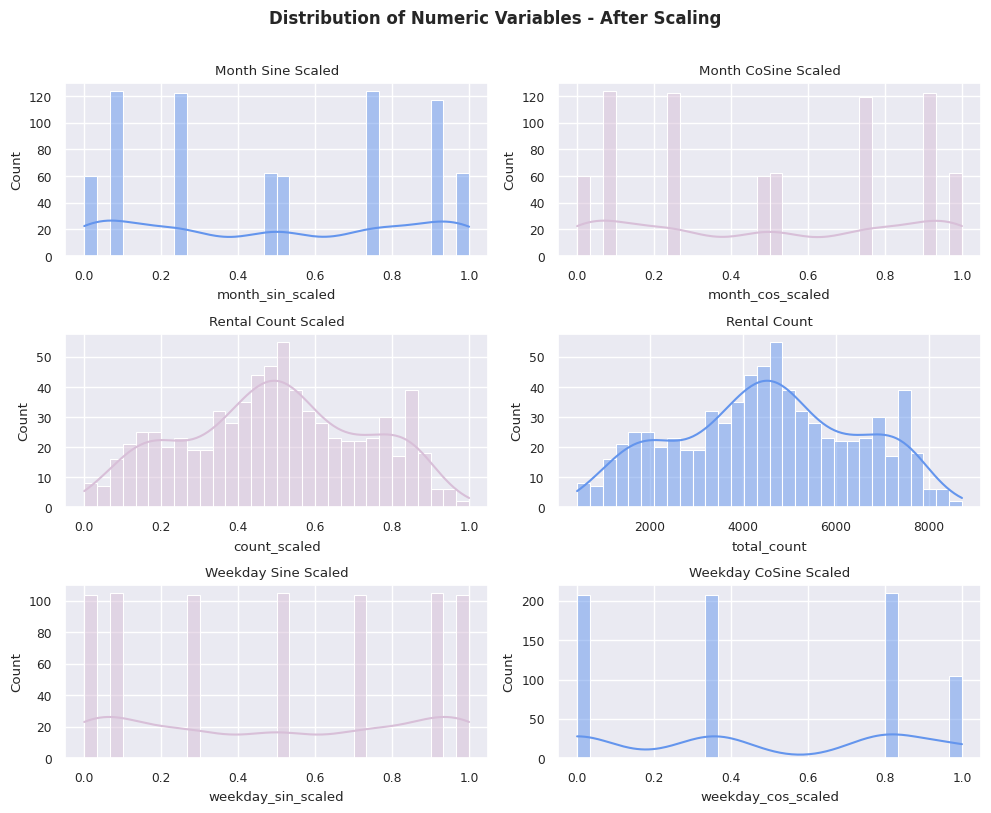

In [ ]:
#--------------------------------------------------------------------------------------#
# Plotting distributions of key numeric variables (After Scaling)
#--------------------------------------------------------------------------------------#
#sns.set(font_scale=0.8)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
fig.suptitle('Distribution of Numeric Variables - After Scaling', fontsize=12, fontweight='bold', y=1.01)

sns.histplot(bike_daily_clean['month_sin_scaled'], bins=30, kde=True, ax=axes[0, 0], color='cornflowerblue')
axes[0, 0].set_title('Month Sine Scaled')

sns.histplot(bike_daily_clean['month_cos_scaled'], bins=30, kde=True, ax=axes[0, 1], color='thistle')
axes[0, 1].set_title('Month CoSine Scaled')

sns.histplot(bike_daily_clean['count_scaled'], bins=30, kde=True, ax=axes[1, 0], color='thistle')
axes[1, 0].set_title('Rental Count Scaled')

sns.histplot(bike_daily_clean['total_count'], bins=30, kde=True, ax=axes[1, 1], color='cornflowerblue')
axes[1, 1].set_title('Rental Count')


sns.histplot(bike_daily_clean['weekday_sin_scaled'], bins=30, kde=True, ax=axes[2, 0], color='thistle')
axes[2, 0].set_title('Weekday Sine Scaled')

sns.histplot(bike_daily_clean['weekday_cos_scaled'], bins=30, kde=True, ax=axes[2, 1], color='cornflowerblue')
axes[2, 1].set_title('Weekday CoSine Scaled')


plt.tight_layout()
plt.show()

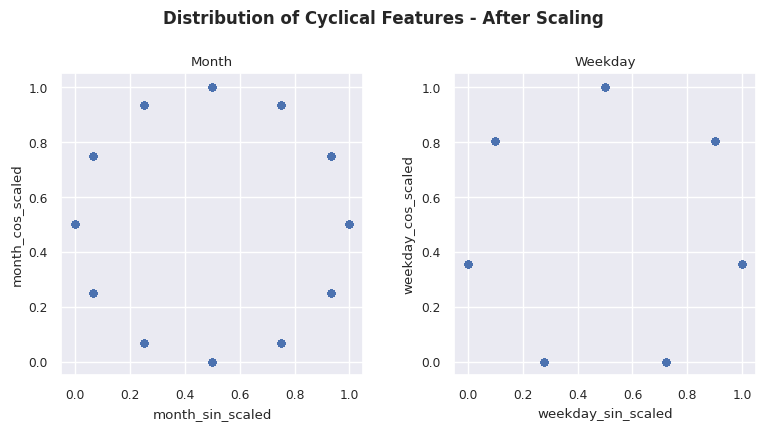

In [ ]:
  # Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.figure.set_size_inches(8, 4)
fig.suptitle('Distribution of Cyclical Features - After Scaling', fontsize=12, fontweight='bold', y=1.03)

# Plot month_sin vs month_cos on the first subplot
bike_daily_clean.plot.scatter('month_sin_scaled', 'month_cos_scaled', ax=ax1).set_aspect('equal')

# Plot weekday vs cnt on the second subplot
bike_daily_clean.plot.scatter('weekday_sin_scaled','weekday_cos_scaled', ax=ax2).set_aspect('equal')

# Set the titles for the subplots
ax1.set_title('Month')
ax2.set_title('Weekday')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#--------------------------------------------------------------------------------------#
# Drop Columns
#--------------------------------------------------------------------------------------#
#create a copy of clean data for further manipulation if required
bike_daily_clean_allcols = bike_daily_clean.copy()

# Drop the 'unecessary columns
bike_daily_clean.drop(['instant', 'atemp', 'weather_condition', 'month', 'weekday', 'casual', 'registered', 'total_count'], axis=1, inplace=True)
bike_daily_clean.drop(['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'], axis=1, inplace=True)

#create a copy of clean data with datetime for remerging later, and then dropping it from the final dataset
bike_daily_clean_with_date = bike_daily_clean.copy()
bike_daily_clean.drop(['datetime'], axis=1, inplace=True)

print("Cleaned Dataset Columns: \n")
bike_daily_clean.info()

Cleaned Dataset Columns: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                731 non-null    int64  
 1   is_holiday          731 non-null    int64  
 2   is_workingday       731 non-null    int64  
 3   temp                731 non-null    float64
 4   humidity            731 non-null    float64
 5   windspeed           731 non-null    float64
 6   season_1            731 non-null    int64  
 7   season_2            731 non-null    int64  
 8   season_3            731 non-null    int64  
 9   season_4            731 non-null    int64  
 10  month_sin_scaled    731 non-null    float64
 11  month_cos_scaled    731 non-null    float64
 12  weekday_sin_scaled  731 non-null    float64
 13  weekday_cos_scaled  731 non-null    float64
 14  count_scaled        731 non-null    float64
dtypes: float64(

In [ ]:
#--------------------------------------------------------------------------------------#
# Store clean data to file
#--------------------------------------------------------------------------------------#
# use the custom function with operation = save,  to save data to file
#read_save_data(colab_directory, 'bike_daily_clean.csv', 'save', bike_daily_clean)

In [ ]:
#function to plot train,test,val split
def train_test_plot2(train_set, val_set, test_set):

    # Plot the dataset splits against the Count
    train_set.loc[ : , "count_scaled"].plot(figsize=(12, 4), legend=True, color='cornflowerblue')
    val_set.loc[ : , "count_scaled"].plot(figsize=(12, 4), legend=True, color='slateblue')
    test_set.loc[ : , "count_scaled"].plot(figsize=(12, 4), legend=True, color='orange')

    # plot the timeseries split partitions of each new split
    plt.legend(["Train Split", "Validation Split", "Test (Holdout) Split"])
    plt.title("Bike Rental Count - Data Split")
    plt.ylabel("Scaled Count")
    plt.xlabel(None)
    plt.show()

In [ ]:
def train_test_plot(train_set, val_set, test_set):
    """
    Plot the training, validation, and test splits of the dataset based on the provided cutoff.

    Args:
    dataset (DataFrame): The dataset containing the time series data.

    Returns: None
    """
    # Plot the dataset splits against the Count
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=train_set, x='dteday', y='count_scaled', color='cornflowerblue', label='Train')
    sns.lineplot(data=val_set, x='dteday', y='count_scaled', color='slateblue',label='Validation')
    sns.lineplot(data=test_set, x='dteday', y='count_scaled', color='orange', label='Test')

    # Add a title and labels
    plt.title("Bike Rental Count - Data Split")
    plt.xlabel('Date')
    plt.ylabel("Scaled Count")
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    # Show the plot
    plt.show()


Data Splitting Ratios: 
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Total Number of Observations: 731


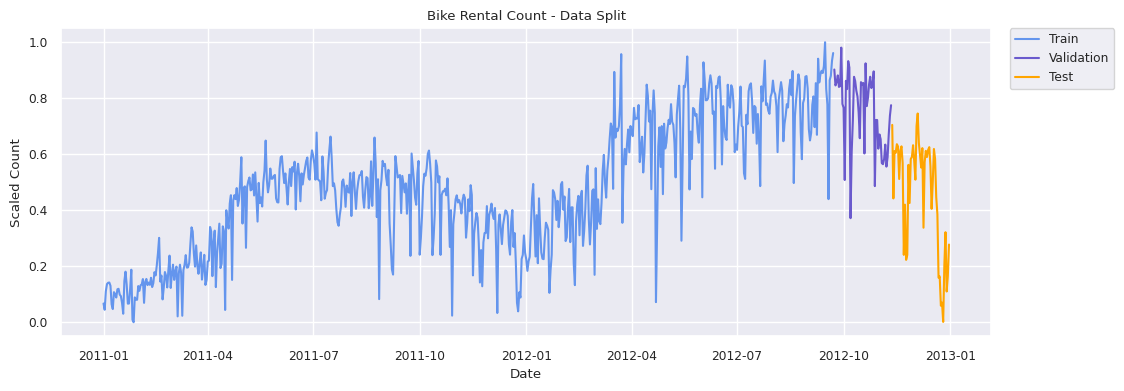

Train Dataset Shape: (631, 15)
Validation Dataset Shape: (50, 15)
Test Dataset Shape: (50, 15)


In [ ]:
#--------------------------------------------------------------------------------------#
# Data Splitting
#--------------------------------------------------------------------------------------#
# create copy of clean dataset for splitting and modelling purposes
bike_daily_data = bike_daily_clean.copy()

# assign test, val and training cut-offs
cutoff = round(len(bike_daily_data) * 0.10)  # 10% of the data
cutoff = 50

test_data_cutoff = cutoff
val_data_cutoff = cutoff
train_data_cutoff = len(bike_daily_data) - val_data_cutoff - test_data_cutoff
print(f'\nData Splitting Ratios: \n' + '+' * 60)
print(f'Total Number of Observations: {len(bike_daily_data)}')

#--------------------------------------------------------------------------------------#
# Create Train, Validation and Holdout(Test) datasets
#--------------------------------------------------------------------------------------#
train_df = bike_daily_data[:train_data_cutoff]
val_df = bike_daily_data[-(val_data_cutoff+test_data_cutoff):-test_data_cutoff]
test_df = bike_daily_data[-test_data_cutoff:]

# Call custom function to Plot the dataset splits against the Count
train_test_plot(train_df, val_df, test_df)

print(f'Train Dataset Shape: {train_df.shape}')
print(f'Validation Dataset Shape: {val_df.shape}')
print(f'Test Dataset Shape: {test_df.shape}')

In [ ]:
#--------------------------------------------------------------------------------------#
# Function to Prepare Timeseries Data
#--------------------------------------------------------------------------------------#
def prepare_data(dataset, split_type):
    # Initialize a list to hold the reshaped input arrays
    sequences = []

    # Get the list of column names
    target_col = dataset.columns.tolist()[-1]     # get last element, target feature
    input_cols = train_df.columns.tolist()[0:-1]  # get all input features, less target

    # Loop through each column name in the list of input columns
    for col in input_cols:
        # Convert the column to a numpy array, reshape it, and add to the list
        seq = array(dataset[col]).reshape((len(dataset[col]), 1))
        sequences.append(seq)

    # Handle the target column
    output_seq = array(dataset[target_col]).reshape((len(dataset[target_col]), 1))

    # Stack all sequences horizontally
    dataset_feed = hstack(sequences + [output_seq])
    # Print the shapes of the input and output sequences
    print(f'{split_type} Shape: {dataset_feed.shape}, Output Shape: {output_seq.shape}')

    return dataset_feed, output_seq

print(f'Function prepare_data() compiled.')

Function prepare_data() compiled.


In [ ]:
#--------------------------------------------------------------------------------------#
# Prepare Datasets: Reshaping and Preparing Timeseries Data
#--------------------------------------------------------------------------------------#
# Call the function to reshape and prepare timeseries data
train_data_feed, train_output_seq = prepare_data(train_df, 'Train')
val_data_feed, val_output_seq = prepare_data(val_df, 'Validation')
test_data_feed, test_output_seq = prepare_data(test_df, 'Test (Holdout)')

print(f'\nDataset Preparation complete.')

Train Shape: (631, 15), Output Shape: (631, 1)
Validation Shape: (50, 15), Output Shape: (50, 1)
Test (Holdout) Shape: (50, 15), Output Shape: (50, 1)

Dataset Preparation complete.


In [ ]:
#--------------------------------------------------------------------------------------#
# Generate Batches of Temporal/Timeseries Data
#--------------------------------------------------------------------------------------#
K.clear_session() # clear previous model from memory
features = train_data_feed.shape[1]    # get number of features
timesteps = 10                         # set number of timesteps in each sample

train_gen = TimeseriesGenerator(train_data_feed, train_output_seq, length=timesteps, batch_size=CONFIG.BATCH_SIZE) #16 batch_size
val_gen = TimeseriesGenerator(val_data_feed, val_output_seq, length=timesteps, batch_size=1)
test_gen = TimeseriesGenerator(test_data_feed, test_output_seq, length=timesteps, batch_size=1)

print(f'Temporal Data Generated.')

Temporal Data Generated.


In [ ]:
#review the shapes of the timeseries data
print("TimeSeriesGenerator Batch Shapes:\n")
print(f"train_gen shapes: {train_gen[0][0].shape} {train_gen[0][1].shape}")
print(f"val_gen shapes: {val_gen[0][0].shape} {val_gen[0][1].shape}")
print(f"test_gen shapes: {test_gen[0][0].shape} {test_gen[0][1].shape}")

TimeSeriesGenerator Batch Shapes:

train_gen shapes: (16, 10, 15) (16, 1)
val_gen shapes: (1, 10, 15) (1, 1)
test_gen shapes: (1, 10, 15) (1, 1)


**Modelling Functions**

In [ ]:
def compile_model(model, learn_rate, optimizer, model_str):
    """
    Compiles a Keras model with specified learning rate and optimizer.
    This function configures the model for training by setting the optimizer, learning rate, loss function, and metrics.

    Args:
        model (tf.keras.Model): The model to be compiled and prepared for training.
        learn_rate (float): The learning rate to be used with the optimizer.
        optimizer (str): The name of the optimizer to use. Currently supports 'adam'.
        model_str (str): Descriptive name or identifier for the model. This is used to identify the model during output messaging.

    Returns:
        None: The function does not return any values.
    """
    # Select optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learn_rate)
    else:
        raise ValueError(f"Unsupported optimizer {optimizer}. Only 'adam' is currently supported.")

    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    print(f'Step: Model {model_str} Compilation complete.')


In [ ]:
def plot_model_loss(model_history, model_title):
    """
    Plots training and validation loss over epochs from a model's training history.

    Args:
        model_history (keras.callbacks.History): History object containing training and validation metrics.
        model_title (str): Title for the plot indicating the model.

    Returns:
        loss_df(DataFrame): Contains loss values for training and validation sets.
    """
    # get training and validation losses
    losses = model_history.history['loss']
    val_losses = model_history.history['val_loss']

    #plot training vs validation loss
    plt.figure(figsize=(12, 4))
    plt.plot(losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.title(f'Loss Evolution by Epoch - {model_title}')
    plt.show()

In [ ]:
def evaluate_model_loss_mse(datagen, model=None, split_name='Train', model_title=None):
    """
    Evaluates the model's performance on a dataset and prints the loss.
    This function is designed to provide a quick snapshot of model performance metrics after the training phase.

    Args:
        datagen (TimeSeriesGenerator object): The data generator or data loader that provides batches of input data and labels.
        model (keras.Model): The model that will be evaluated.
        split_name (str): Descriptive name of the dataset split being evaluated (e.g., 'Train', 'Validation', 'Test').
        model_title (str): To be used for the loss_df.

    Returns:
        loss_df (DataFrame): A DataFrame containing the model's loss values.
    """
    eval_loss = model.evaluate(datagen, verbose=0)  # Evaluate the model on the dataset
    print(f'+' * 60)
    print(f"{split_name} Loss (MSE): {eval_loss}\n")

    loss_df = pd.DataFrame()  # Create an empty DataFrame
    loss_results = {}         # Create empty dict to store loss results

    # Create dictionary with loss values
    loss_results = {
      'Model': [model_title],
      'Set': [split_name],
      'Loss': [eval_loss]
    }
    # Create a DataFrame containing loss_results
    loss_df = pd.concat([loss_df, pd.DataFrame(loss_results)], ignore_index = True)

    return loss_df  # Return the DataFrame

In [ ]:
def plot_actual_vs_predicted(dataset, model_str=None):
    """
    Generates a line plot to compare actual and predicted values from a dataset.
    Args:
        dataset (DataFrame): Pandas DataFrame with 'Actual_inv' and 'Predicted_inv' columns containing the respective values.
        model_str (str): Descriptive name or identifier for the model. This is used to identify the model during output messaging.

    Returns:
        None: Displays a matplotlib plot without returning any value.
    """
    print('\n\nPlotting Actuals vs Predictions (On count_scaled for review purposes)...\n')
    plt.figure(figsize=(12,4))
    plt.title(f'{model_str} - Actual vs Predicted Values')
    plt.plot(dataset['Actual'], color='cornflowerblue', label="Actual")
    plt.plot(dataset['Predicted'], color='red', label="Predicted")
    plt.xlabel('Timeseries')
    plt.ylabel('Values')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()



**Model Prediction Helper Functions**

In [ ]:
# function to do predictions on unseen/holdout dataset - model.predict()
def model_predict(model, generator, model_name_str=None, split_type=None):
  print(f"Performing Predictions on {split_type} Set: \n")
  x=[]
  y=[]
  prediction_values_df = pd.DataFrame()  # Create an empty DataFrame to store the predictions

  for i in range(len(generator)):
    x, y = generator[i]

    x_actual = array(x).reshape((1, timesteps, features)) #reshape data for prediction
    y_pred = model.predict(x_actual, verbose=0)           # predict on the given dataset

    # Calculate performance metrics for each model and return
    actual_pred_values = {}
    actual_pred_values = {
      'Model': [f'{model_name_str}'],
      'Actual': [y[0][0]],
      'Predicted': [y_pred[0][0]],
    }
    # Create a DataFrame containing actual and predictied values
    prediction_values_df = pd.concat([prediction_values_df, pd.DataFrame(actual_pred_values)], ignore_index = True)

  return prediction_values_df # return DataFrame with actuals/prediction values

In [ ]:
#function to calculate and tabulate performance metrics for evaluation
def calculate_metrics(predictions_dataset=pd.DataFrame(), model_name_str=None, split_type=None):
  # get actual and predicted values
  actuals = predictions_dataset['Actual']
  predictions = predictions_dataset['Predicted']
  model_name = predictions_dataset['Model'][0]

  # calculate the metrics
  mean = predictions_dataset['Actual'].mean()
  mae = mean_absolute_error(actuals, predictions)
  mse = mean_squared_error(actuals, predictions)
  rmse = mean_squared_error(actuals, predictions, squared=False)
  correctness = 100 - ((mae/mean) * 100)
  r2 = r2_score(actuals, predictions)
  #mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

  print(f'Model: {model_name}')
  print(f'Calculating Performance...\n')

  model_performance_df = pd.DataFrame()  # Create an empty DataFrame to store the results
  metrics_results = {}
  # Calculate performance metrics for each model and return
  metrics_results = {
      'Model': [f'{model_name_str}'],
      'Split': [f'{split_type}'],
      'MSE': [mse],
      'MAE': [mae],
      'RMSE': [rmse],
      'R2': [r2],
      'Correctness': [round(correctness, 5)],
  }

  # Create a DataFrame containing the metrics values
  model_performance_df = pd.concat([model_performance_df, pd.DataFrame(metrics_results)], ignore_index = True)

  return model_performance_df   #Return the DataFrame

# Section 4: Modelling - Base RNN

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.1 Define Model Architecture
#--------------------------------------------------------------------------------------#
print(f"Model Input Shape (timesteps, features) = ({timesteps}, {features})")

K.clear_session() # clear previous model from memory
tf.keras.backend.clear_session()

# defining layers of a super basic RNN model
def create_rnn_model():
  # since predicting a continuous value/timeseries add this layer
  model = Sequential()

  # define RNN layer and dropout
  model.add(SimpleRNN(units=50, activation='relu', input_shape=(timesteps, features), return_sequences = False))
  model.add(Dropout(0.2)) #dropout to avoid overfitting

  # output layer
  model.add(Dense(units=1, activation='relu'))
  model.summary()
  return model

rnn_model_v1 = create_rnn_model()   # define conv RNN model V1

Model Input Shape (timesteps, features) = (10, 15)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                3300      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 3351 (13.09 KB)
Trainable params: 3351 (13.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#--------------------------------------------------------------------------------------#
# 4.2 Compile Model with Optimizers
#--------------------------------------------------------------------------------------#
# call custom function to compile model
#compile_model(rnn_model_v1, 0.0001, "adam", "Base RNN")
compile_model(rnn_model_v1, 0.001, "adam", "Base RNN")

Step: Model Base RNN Compilation complete.


In [ ]:
#--------------------------------------------------------------------------------------#
# 4.3 Setting Callbacks List
#--------------------------------------------------------------------------------------#
# define callbacks list
rnn_callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose = 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose = 1),
    ModelCheckpoint(filepath='rnn_best_model.h5', monitor='val_loss',mode='min', save_weights_only=True, save_best_only=True)
]
print('Step: Setting Callbacks and Checkpoints complete.')

Step: Setting Callbacks and Checkpoints complete.


In [ ]:
#--------------------------------------------------------------------------------------#
# 4.4 Training the Base RNN Model
#--------------------------------------------------------------------------------------#
# Fit the RNN Model
rnn_history_v1 = rnn_model_v1.fit(train_gen, epochs=150, verbose=1, validation_data=val_gen, callbacks=rnn_callbacks)

print('Step: RNN Model Training/Fitting complete.')

Epoch 1/150
39/39 [==============================] - 2s 12ms/step - loss: 0.0969 - val_loss: 0.0302 - lr: 0.0010
Epoch 2/150
39/39 [==============================] - 0s 6ms/step - loss: 0.0586 - val_loss: 0.0240 - lr: 0.0010
Epoch 3/150
39/39 [==============================] - 0s 6ms/step - loss: 0.0454 - val_loss: 0.0221 - lr: 0.0010
Epoch 4/150
39/39 [==============================] - 0s 6ms/step - loss: 0.0365 - val_loss: 0.0265 - lr: 0.0010
Epoch 5/150
33/39 [========================>.....] - ETA: 0s - loss: 0.0312
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
39/39 [==============================] - 0s 6ms/step - loss: 0.0307 - val_loss: 0.0381 - lr: 0.0010
Epoch 6/150
39/39 [==============================] - 0s 6ms/step - loss: 0.0302 - val_loss: 0.0213 - lr: 2.0000e-04
Epoch 7/150
39/39 [==============================] - 0s 6ms/step - loss: 0.0284 - val_loss: 0.0230 - lr: 2.0000e-04
Epoch 8/150
33/39 [========================>.....] - ETA: 0s - los

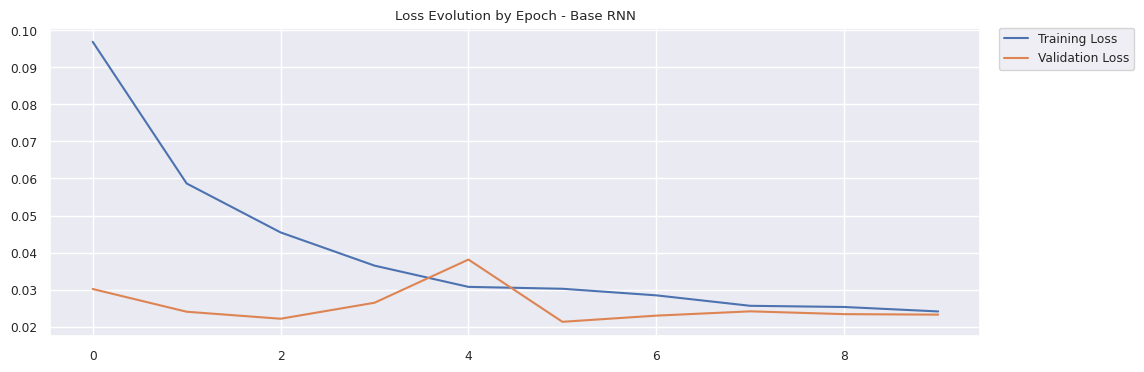

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.5 Evaluate Loss and MSE/MAE Evolution - Training and Validation
#--------------------------------------------------------------------------------------#
# Call custom Function to evaluate loss of the trained model
plot_model_loss(rnn_history_v1, 'Base RNN')

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.6 Evaluation vs. Prediction: model.evaluate()
#--------------------------------------------------------------------------------------#
# load model weights
#rnn_model_v1.load_weights('rnn_best_model.h5')

# get model accuracy and loss
rnn_v1_train_loss = evaluate_model_loss_mse(train_gen, rnn_model_v1, 'Train', 'RNN Base')
rnn_v1_val_loss = evaluate_model_loss_mse(val_gen, rnn_model_v1,'Validation', 'RNN Base')
rnn_v1_test_loss = evaluate_model_loss_mse(test_gen, rnn_model_v1,'Testing', 'RNN Base')

#merged_losses_df = pd.concat([rnn_v1_train_loss, rnn_v1_val_loss, rnn_v1_test_loss], ignore_index=True)
#print(merged_losses_df)

print('\nStep: Evaluate Loss (Mean Squared Error) complete.')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train Loss (MSE): 0.01298465859144926

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Validation Loss (MSE): 0.021302299574017525

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing Loss (MSE): 0.02889646217226982


Step: Evaluate Loss (Mean Squared Error) complete.


Performing Predictions on Validation Set: 

Model: RNN Base
Calculating Performance...

      Model       Split       MSE       MAE      RMSE        R2  Correctness
0  RNN Base  Validation  0.021302  0.118557  0.145953 -0.188512     83.94407


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



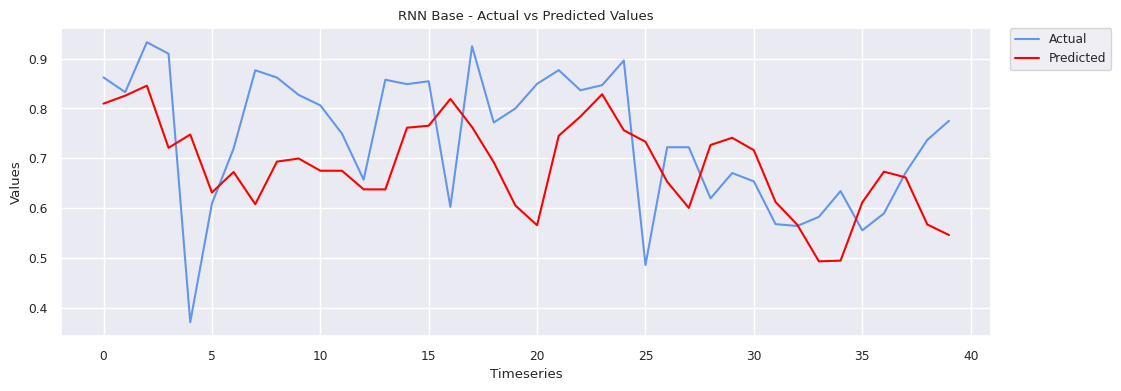

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.7 Predict on Validation Dataset
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
rnn_v1_preds_val = model_predict(rnn_model_v1, val_gen, 'RNN Base', 'Validation')

# call custom function to calculate model performance after prediction
rnn_v1_val_results = calculate_metrics(rnn_v1_preds_val, 'RNN Base', 'Validation')

#print the resulting metrics
print(rnn_v1_val_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(rnn_v1_preds_val, 'RNN Base')

Performing Predictions on Test Set: 

Model: RNN Base
Calculating Performance...

      Model Split       MSE       MAE     RMSE        R2  Correctness
0  RNN Base  Test  0.028896  0.132027  0.16999  0.296951      69.3688


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



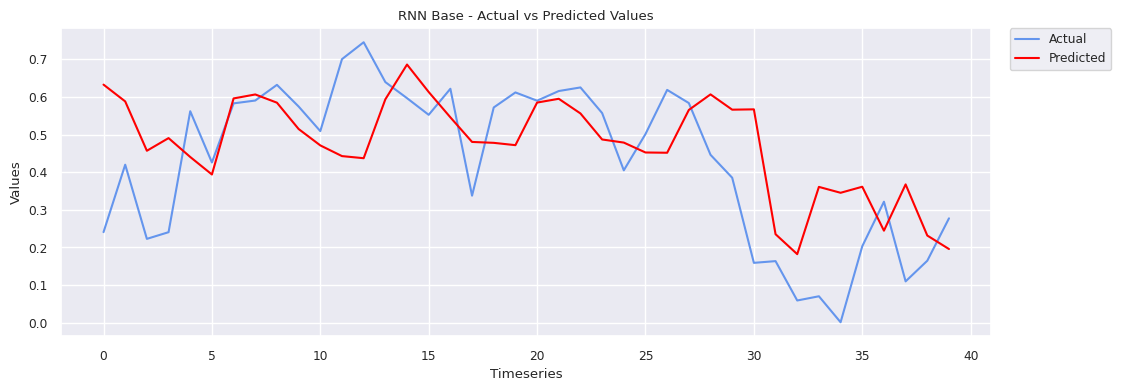

In [ ]:
#--------------------------------------------------------------------------------------#
# 4.8 Predict on Test (Holdout) Dataset
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
rnn_v1_preds_test = model_predict(rnn_model_v1, test_gen, 'RNN Base', 'Test')

# call custom function to calculate model performance after prediction
rnn_v1_test_results = calculate_metrics(rnn_v1_preds_test, 'RNN Base', 'Test')

#print the resulting metrics
print(rnn_v1_test_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(rnn_v1_preds_test, 'RNN Base')

# **Section 5: Modelling - Base LSTM**

In [ ]:
#--------------------------------------------------------------------------------------#
# 5.1 Define Model Architecture - LSTM
#--------------------------------------------------------------------------------------#
print(f"Model Input Shape (timesteps, features) = ({timesteps}, {features})")
#timesteps = 10 # Number of time steps to look back

K.clear_session() # clear previous model from memory

def create_LSTM_model():

    # since predicting a continuous value, dealing with continuous values
    model = Sequential()

    #adding first LSTM and dropout to avoid overfitting
    model.add(LSTM(units = 64, input_shape = (timesteps, features), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 32, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))

    #adding the output layer
    model.add(Dense(units=1))
    # print model architechture
    model.summary()

    return model

lstm_model_v1 = create_LSTM_model()   # define LSTM model V1


Model Input Shape (timesteps, features) = (10, 15)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            20480     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            12416     
                                                                 
 dropout_2 (Dropout)         (None, 10, 32)            0         
                                                                 
 dens

Step: Model LSTM Base Compilation complete.
Epoch 1/150
39/39 [==============================] - 4s 31ms/step - loss: 0.2693 - val_loss: 0.5138
Epoch 2/150
39/39 [==============================] - 1s 16ms/step - loss: 0.2203 - val_loss: 0.4057
Epoch 3/150
39/39 [==============================] - 1s 16ms/step - loss: 0.1568 - val_loss: 0.2803
Epoch 4/150
39/39 [==============================] - 1s 16ms/step - loss: 0.1275 - val_loss: 0.2580
Epoch 5/150
39/39 [==============================] - 1s 15ms/step - loss: 0.1183 - val_loss: 0.2544
Epoch 6/150
39/39 [==============================] - 1s 15ms/step - loss: 0.1112 - val_loss: 0.2425
Epoch 7/150
39/39 [==============================] - 1s 16ms/step - loss: 0.1057 - val_loss: 0.2254
Epoch 8/150
39/39 [==============================] - 1s 16ms/step - loss: 0.0998 - val_loss: 0.2137
Epoch 9/150
39/39 [==============================] - 1s 16ms/step - loss: 0.0935 - val_loss: 0.2030
Epoch 10/150
39/39 [==============================] - 1s

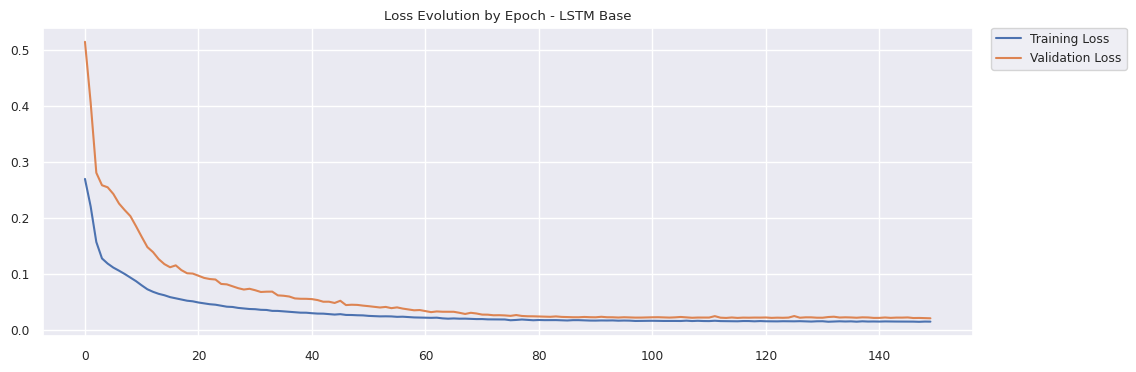

In [ ]:
#--------------------------------------------------------------------------------------#
# 5.2 Compile and Fit - LSTM Base
#--------------------------------------------------------------------------------------#
# call custom function to compile model
#compile_model(lstm_model_v1, CONFIG.init_learn_rate, "adam", "LSTM Base")
compile_model(lstm_model_v1, 0.0001, "adam", "LSTM Base")

# setting checkpoint
lstm_callbacks = [
    #EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose = 1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose = 1),
    ModelCheckpoint(filepath='lstm_best_model.h5', monitor='val_loss',mode='min', save_weights_only=True, save_best_only=False)
]

# Fit the RNN Model
lstm_history_v1 = lstm_model_v1.fit(train_gen, epochs=150, verbose=1, validation_data=val_gen, callbacks=lstm_callbacks)

# Call custom Function to evaluate loss of the trained model
plot_model_loss(lstm_history_v1, 'LSTM Base')

In [ ]:
#--------------------------------------------------------------------------------------#
# 5.3 Evaluation vs. Prediction: model.evaluate()
#--------------------------------------------------------------------------------------#
#load model weights
#lstm_model_v1.load_weights('rnn_best_model.h5')

# get model accuracy and loss
lstm_v1_train_loss = evaluate_model_loss_mse(train_gen, lstm_model_v1, 'Train', 'LSTM Base')
lstm_v1_val_loss = evaluate_model_loss_mse(val_gen, lstm_model_v1,'Validation', 'LSTM Base')
lstm_v1_test_loss = evaluate_model_loss_mse(test_gen, lstm_model_v1,'Testing', 'LSTM Base')

#merged_losses_df = pd.concat([merged_losses_df, lstm_v1_train_loss, lstm_v1_val_loss, lstm_v1_test_loss], ignore_index=True)
#print(merged_losses_df)

print('\nStep: Evaluate Loss (Mean Squared Error) complete.')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train Loss (MSE): 0.0124382758513093

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Validation Loss (MSE): 0.020801212638616562

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing Loss (MSE): 0.058942388743162155


Step: Evaluate Loss (Mean Squared Error) complete.


Performing Predictions on Validation Set: 

Model: LSTM Base
Calculating Performance...

       Model       Split       MSE       MAE      RMSE        R2  Correctness
0  LSTM Base  Validation  0.049169  0.189231  0.221741 -1.743277     74.37283


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



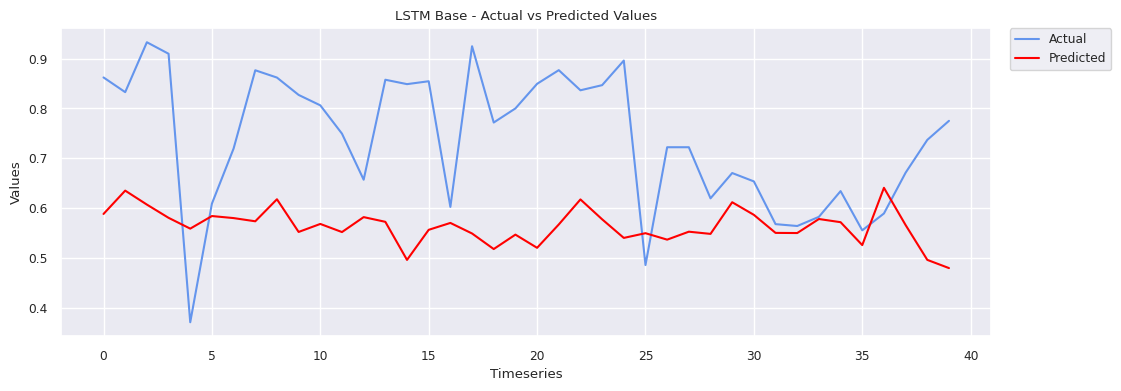

In [ ]:
#--------------------------------------------------------------------------------------#
# 5.4 Predict on validation Dataset - Base LSTM
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
lstm_v1_preds_val = model_predict(lstm_model_v1, val_gen, 'LSTM Base', 'Validation')

# call custom function to calculate model performance after prediction
lstm_v1_val_results = calculate_metrics(lstm_v1_preds_val, 'LSTM Base', 'Validation')

#print the resulting metrics
print(lstm_v1_val_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(lstm_v1_preds_val, 'LSTM Base')

Performing Predictions on Test Set: 

Model: LSTM Base
Calculating Performance...

       Model Split       MSE       MAE      RMSE        R2  Correctness
0  LSTM Base  Test  0.044132  0.169989  0.210075 -0.073718     60.56141


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



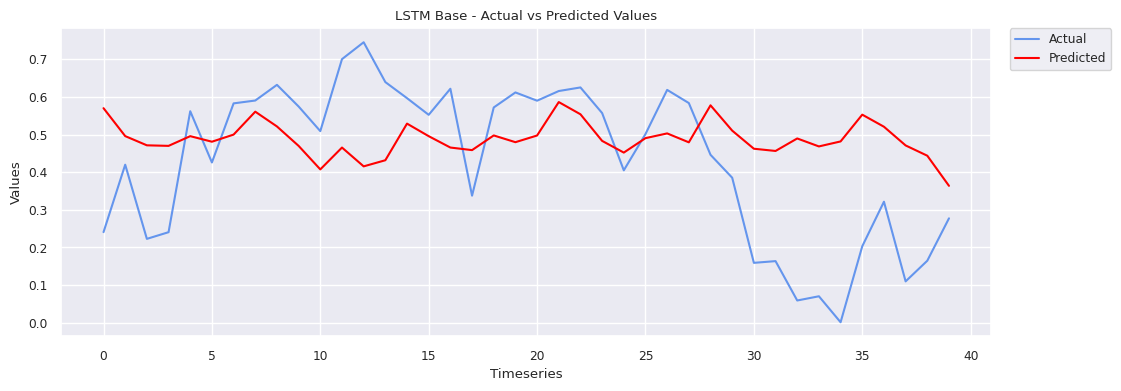

In [ ]:
#--------------------------------------------------------------------------------------#
# 5.5 Predict on Test (Holdout) Dataset - Base LSTM
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
lstm_v1_preds_test = model_predict(lstm_model_v1, test_gen, 'LSTM Base', 'Test')

# call custom function to calculate model performance after prediction
lstm_v1_test_results = calculate_metrics(lstm_v1_preds_test, 'LSTM Base', 'Test')

#print the resulting metrics
print(lstm_v1_test_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(lstm_v1_preds_test, 'LSTM Base')

In [ ]:
#del merged_losses_df, merged_metrics_df

# Section 6: Modelling - Base GRU

In [ ]:
#--------------------------------------------------------------------------------------#
#6.1 Define Model Architecture - GRU
#--------------------------------------------------------------------------------------#
print(f"Model Input Shape (timesteps, features) = ({timesteps}, {features})")
#timesteps = 10 # Number of time steps to look back

K.clear_session() # clear previous model from memory
tf.keras.backend.clear_session()

def create_GRU_model():

    # since predicting a timeseries value, use sequential
    model = Sequential()

    #adding 3 GRU and dropout layer to avoid overfitting
    #model.add(GRU(units = CONFIG.init_unit_size, input_shape = (timesteps, features), activation='relu', return_sequences=True))
    model.add(GRU(units = 64, input_shape = (timesteps, features), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))

    #adding the output layer
    model.add(Dense(units=1))

    # print model architecture
    model.summary()

    return model

gru_model_v1 = create_GRU_model()   # define GRU model V1


Model Input Shape (timesteps, features) = (10, 15)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 64)            15552     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 10, 64)            24960     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dens

Step: Model GRU Base Compilation complete.
Epoch 1/100
39/39 [==============================] - 5s 27ms/step - loss: 0.2570 - val_loss: 0.5167
Epoch 2/100
39/39 [==============================] - 1s 14ms/step - loss: 0.1749 - val_loss: 0.3497
Epoch 3/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0951 - val_loss: 0.1701
Epoch 4/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0581 - val_loss: 0.1106
Epoch 5/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0478 - val_loss: 0.1069
Epoch 6/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0458 - val_loss: 0.1069
Epoch 7/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0381 - val_loss: 0.0823
Epoch 8/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0296 - val_loss: 0.0791
Epoch 9/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0318 - val_loss: 0.0805
Epoch 10/100
39/39 [==============================] - 1s 

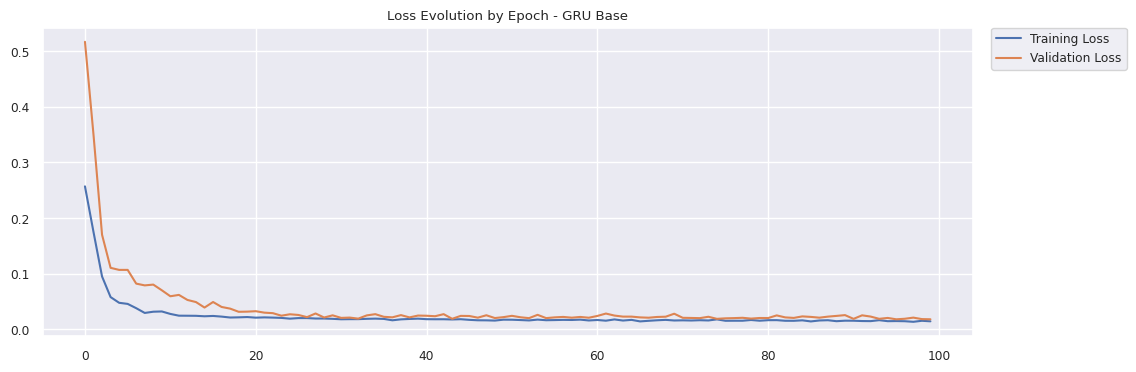

In [ ]:
#--------------------------------------------------------------------------------------#
# 6.2 Compile and Fit - GRU Base
#--------------------------------------------------------------------------------------#
# call custom function to compile model
#compile_model(gru_model_v1, CONFIG.init_learn_rate, "adam", "GRU Base")
compile_model(gru_model_v1, 0.0001, "adam", "GRU Base")

# setting checkpoint
gru_callbacks = [
    #ModelCheckpoint(filepath='best_model_gru1.h5', monitor='val_loss',mode='min', save_weights_only=True, save_best_only=True)
]

# Fit the GRU Model
gru_history_v1 = gru_model_v1.fit(train_gen, epochs=100, verbose=1, validation_data=val_gen, callbacks=gru_callbacks)

# Call custom Function to evaluate loss of the trained model
plot_model_loss(gru_history_v1, 'GRU Base')

In [ ]:
#--------------------------------------------------------------------------------------#
# 6.3 Evaluation vs. Prediction: model.evaluate()
#--------------------------------------------------------------------------------------#
#load model weights
#gru_model_v1.load_weights('best_model_gru1.h5')

# get model accuracy and loss
gru_v1_train_loss = evaluate_model_loss_mse(train_gen, gru_model_v1, 'Train', 'GRU Base')
gru_v1_val_loss = evaluate_model_loss_mse(val_gen, gru_model_v1,'Validation', 'GRU Base')
gru_v1_test_loss = evaluate_model_loss_mse(test_gen, gru_model_v1,'Testing', 'GRU Base')

#merged_losses_df = pd.concat([merged_losses_df, gru_v1_train_loss, gru_v1_val_loss, gru_v1_test_loss], ignore_index=True)
#print(merged_losses_df)

print('\nStep: Evaluate Loss (Mean Squared Error) complete.')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train Loss (MSE): 0.010331384837627411

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Validation Loss (MSE): 0.018194353207945824

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing Loss (MSE): 0.0340694859623909


Step: Evaluate Loss (Mean Squared Error) complete.


Performing Predictions on Validation Set: 

Model: GRU Base
Calculating Performance...

      Model       Split       MSE       MAE      RMSE        R2  Correctness
0  GRU Base  Validation  0.018194  0.117943  0.134886 -0.015111     84.02725


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



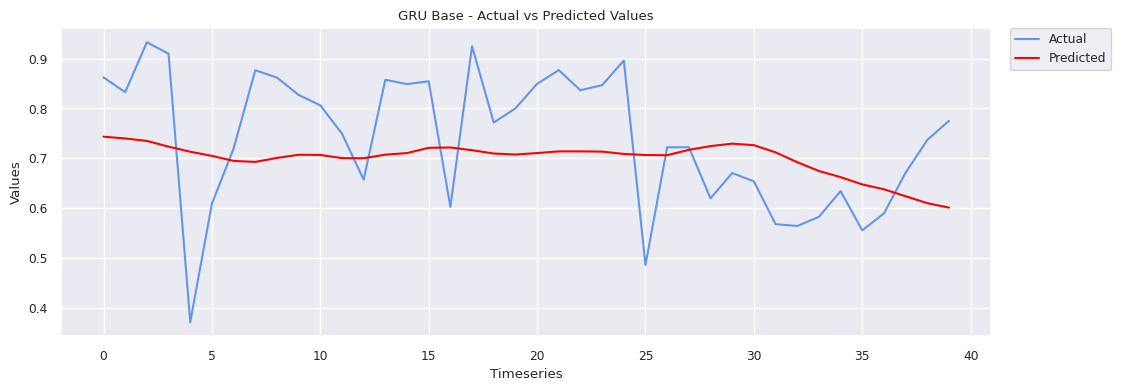

In [ ]:
#--------------------------------------------------------------------------------------#
# 6.4 Predict on validation Dataset - Base GRU
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
gru_v1_preds_val = model_predict(gru_model_v1, val_gen, 'GRU Base', 'Validation')

# call custom function to calculate model performance after prediction
gru_v1_val_results = calculate_metrics(gru_v1_preds_val, 'GRU Base', 'Validation')

#print the resulting metrics
print(gru_v1_val_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(gru_v1_preds_val, 'GRU Base')

Performing Predictions on Test Set: 

Model: GRU Base
Calculating Performance...

      Model Split       MSE       MAE      RMSE        R2  Correctness
0  GRU Base  Test  0.034069  0.132266  0.184579  0.171091     69.31335


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



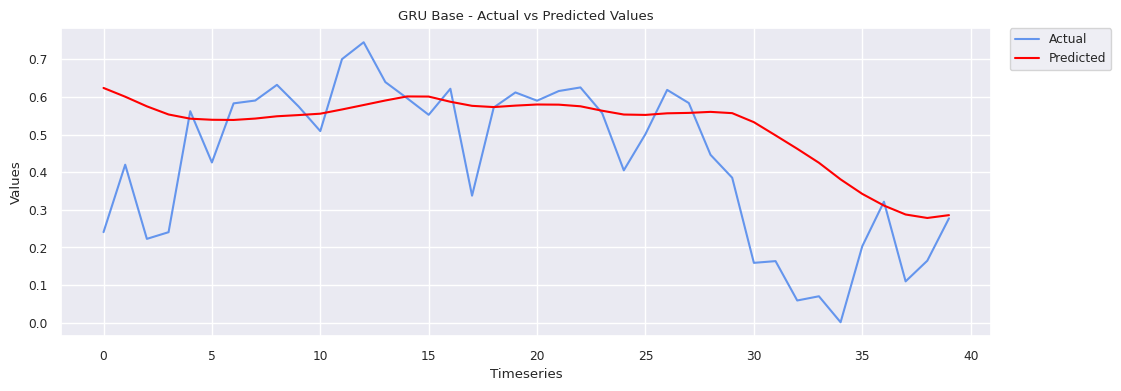

In [ ]:
#--------------------------------------------------------------------------------------#
# 6.5 Predict on Test (Holdout) Dataset - Base GRU
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
gru_v1_preds_test = model_predict(gru_model_v1, test_gen, 'GRU Base', 'Test')

# call custom function to calculate model performance after prediction
gru_v1_test_results = calculate_metrics(gru_v1_preds_test, 'GRU Base', 'Test')

#print the resulting metrics
print(gru_v1_test_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(gru_v1_preds_test, 'GRU Base')

# Section 7: Base Models Evaluation

In [ ]:
#del merged_metrics_df      #for testing purposes, uncomment when needed
#val_gen.data

In [ ]:
#--------------------------------------------------------------------------------------#
# Merge Model Results - Test (Holdout Set)
#--------------------------------------------------------------------------------------#
merged_metrics_df = pd.concat([rnn_v1_test_results
                               ,lstm_v1_test_results
                               ,gru_v1_test_results
                               ], ignore_index=True)
merged_metrics_df

,Model,Split,MSE,MAE,RMSE,R2,Correctness
0,RNN Base,Test,0.028896,0.132027,0.169990,0.296951,69.36880
1,LSTM Base,Test,0.044132,0.169989,0.210075,-0.073718,60.56141
2,GRU Base,Test,0.034069,0.132266,0.184579,0.171091,69.31335


In [ ]:
#--------------------------------------------------------------------------------------#
# Merge Model Results - Validation Set
#--------------------------------------------------------------------------------------#
merged_metrics_val_df = pd.concat([rnn_v1_val_results
                               ,lstm_v1_val_results
                               ,gru_v1_val_results
                               ], ignore_index=True)
merged_metrics_val_df

,Model,Split,MSE,MAE,RMSE,R2,Correctness
0,RNN Base,Validation,0.021302,0.118557,0.145953,-0.188512,83.94407
1,LSTM Base,Validation,0.049169,0.189231,0.221741,-1.743277,74.37283
2,GRU Base,Validation,0.018194,0.117943,0.134886,-0.015111,84.02725


In [ ]:
#--------------------------------------------------------------------------------------#
# Merge Model Results
#--------------------------------------------------------------------------------------#
print('Compilation of Model Losses of Different datasets')
#del merged_losses_df
#merged_losses_df = pd.concat([rnn_v1_train_loss, rnn_v1_val_loss, rnn_v1_test_loss,
#                              lstm_v1_train_loss, lstm_v1_val_loss, lstm_v1_test_loss,
#                              gru_v1_train_loss, gru_v1_val_loss, gru_v1_test_loss], ignore_index=True)
#merged_losses_df

Compilation of Model Losses of Different datasets


# Section 8 - Part 1: Hyperparameter Tuning on GRU, Using HyperBand
**Let's see if we can improve it further!!!**

In [ ]:
#installing kerastuner
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
#load libraries
from keras_tuner import RandomSearch, Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
# build GRU model for RandomSearch
# here we simplify our model with no dropout and with 1 hidden layer
#  since adding a dropout makes the results worst

K.clear_session() # clear previous model from memory
tf.keras.backend.clear_session()
timesteps1=10

def build_gru_model(hp):
    # since predicting a timeseries value, use sequential
    model = Sequential()

    # Define hyperparameter choices for regularization
    reg_type = hp.Choice('regularizer_type', ['l1', 'l2', 'l1_l2'])
    if reg_type == 'l1':
        reg = l1(0.01)
    elif reg_type == 'l2':
        reg = l2(0.01)
    else:
        reg = l1_l2(l1=0.01, l2=0.01)

    #adding 3 GRU and dropout layer to avoid overfitting
    model.add(GRU(units = hp.Int('units1', min_value=10, max_value=100, step=10),
                  input_shape = (timesteps1, features),
                  activation=hp.Choice('activation1', values=['relu', 'tanh']),
                  kernel_regularizer=reg,
                  return_sequences=False))
    #model.add(Dropout(rate = hp.Float('dropout_rate', min_value=0.01, max_value=0.04, step=0.1)))

    #model.add(GRU(units = hp.Int('units2', min_value=32, max_value=128, step=16), activation=hp.Choice('activation2', values=['relu', 'tanh']), return_sequences=True))
    #model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.01, max_value=0.04, step=0.1)))

    #model.add(GRU(units = hp.Int('units3', min_value=32, max_value=128, step=16), activation=hp.Choice('activation3', values=['relu', 'tanh']), return_sequences=False))
    #model.add(Dropout(rate=hp.Float('dropout_rate3', min_value=0.01, max_value=0.04, step=0.1)))


    #adding the output layer
    model.add(Dense(units=1, activation='linear'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')

    return model

In [ ]:
# setting up the Tuner with HyperBand
tuner_hyper = Hyperband(build_gru_model,
                     objective='val_loss',
                     max_epochs=30,
                     factor=3,
                     directory='hyperband_dir',
                     project_name='gru_hyperband_tuner')

#Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# running the search
tuner_hyper.search(train_gen, epochs=100, validation_data=(val_gen), callbacks=[stop_early])
print('Step: Running the Search Done.')

# tuner summary results
tuner_hyper.results_summary()

Trial 90 Complete [00h 00m 14s]
val_loss: 0.018946044147014618

Best val_loss So Far: 0.01603737473487854
Total elapsed time: 00h 06m 58s
Step: Running the Search Done.
Results summary
Results in hyperband_dir/gru_hyperband_tuner
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0051 summary
Hyperparameters:
regularizer_type: l2
units1: 30
activation1: relu
learning_rate: 0.01
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0047
Score: 0.01603737473487854

Trial 0088 summary
Hyperparameters:
regularizer_type: l2
units1: 80
activation1: relu
learning_rate: 0.01
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.016051288694143295

Trial 0050 summary
Hyperparameters:
regularizer_type: l2
units1: 70
activation1: relu
learning_rate: 0.01
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.016090629622340202

Trial 0067 summary
Hyperparameters:
re

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_hyper.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal parameters are:\n
learning_rate: {best_hps.get('learning_rate')}
units1: {best_hps.get('units1')}
activation1: {best_hps.get('activation1')}
regularizer_type: {best_hps.get('regularizer_type')}
""")



The hyperparameter search is complete. The optimal parameters are:

learning_rate: 0.01
units1: 30
activation1: relu
regularizer_type: l2



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
gru_hyperband_model = tuner_hyper.hypermodel.build(best_hps)
gru_hyperband_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 30)                4230      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4261 (16.64 KB)
Trainable params: 4261 (16.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#train model with tune hyperparameters
# Fit the Tuned GRU Model
gru_history_hyper = gru_hyperband_model.fit(train_gen, epochs=100, verbose=1, validation_data=val_gen)

Epoch 1/100
39/39 [==============================] - 2s 14ms/step - loss: 0.1353 - val_loss: 0.0611
Epoch 2/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0435 - val_loss: 0.0363
Epoch 3/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0305 - val_loss: 0.0292
Epoch 4/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0255 - val_loss: 0.0380
Epoch 5/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0238 - val_loss: 0.0319
Epoch 6/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0180 - val_loss: 0.0185
Epoch 7/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0161 - val_loss: 0.0201
Epoch 8/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0179
Epoch 9/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0186
Epoch 10/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0175 - val_loss: 0.0205
Epoch 11

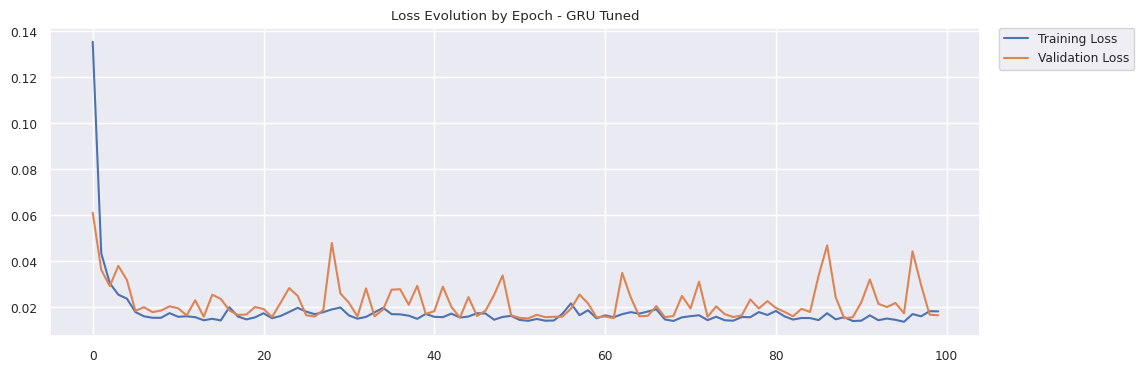

In [ ]:
# Call custom Function to evaluate loss of the trained model
plot_model_loss(gru_history_hyper, 'GRU Tuned')

In [ ]:
#--------------------------------------------------------------------------------------#
# Evaluation vs. Prediction: model.evaluate()
#--------------------------------------------------------------------------------------#
# get model accuracy and loss
gru_tuned_train_loss = evaluate_model_loss_mse(train_gen, gru_hyperband_model, 'Train', 'GRU Tuned')
gru_tuned_val_loss = evaluate_model_loss_mse(val_gen, gru_hyperband_model,'Validation', 'GRU Tuned')
gru_tuned_test_loss = evaluate_model_loss_mse(test_gen, gru_hyperband_model,'Testing', 'GRU Tuned')

#merged_losses_df = pd.concat([merged_losses_df, gru_tuned_train_loss, gru_tuned_val_loss, gru_tuned_test_loss], ignore_index=True)
#print(merged_losses_df)

print('\nStep: Evaluate Loss (Mean Squared Error) complete.')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train Loss (MSE): 0.013820761814713478

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Validation Loss (MSE): 0.016576634719967842

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing Loss (MSE): 0.03301502764225006


Step: Evaluate Loss (Mean Squared Error) complete.


Performing Predictions on Validation Set: 

Model: GRU Tuned
Calculating Performance...

       Model       Split       MSE       MAE      RMSE        R2  Correctness
0  GRU Tuned  Validation  0.013981  0.093547  0.118243  0.219947     87.33116


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



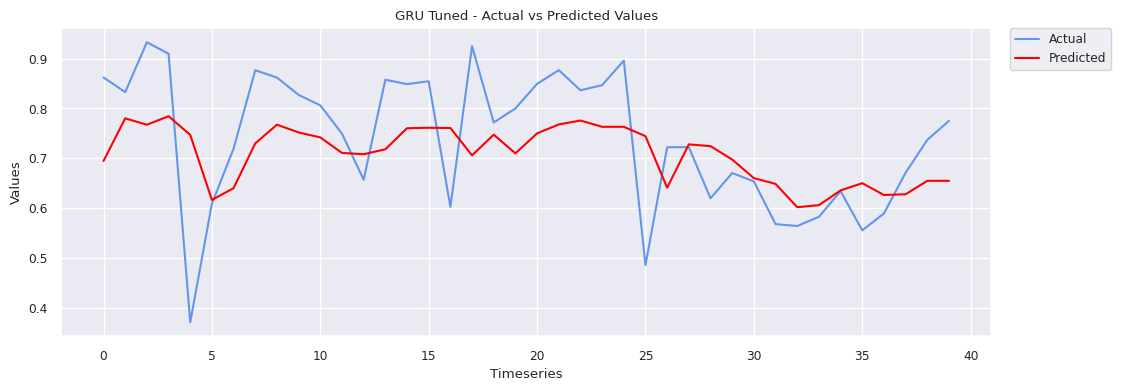

In [ ]:
#--------------------------------------------------------------------------------------#
# Predict on validation Dataset - Tuned GRU
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
gru_tuned_preds_val = model_predict(gru_hyperband_model, val_gen, 'GRU Tuned', 'Validation')

# call custom function to calculate model performance after prediction
gru_tuned_val_results = calculate_metrics(gru_tuned_preds_val, 'GRU Tuned', 'Validation')

#print the resulting metrics
print(gru_tuned_val_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(gru_tuned_preds_val, 'GRU Tuned')

Performing Predictions on Test Set: 

Model: GRU Tuned
Calculating Performance...

       Model Split      MSE       MAE      RMSE        R2  Correctness
0  GRU Tuned  Test  0.03042  0.129753  0.174412  0.259891     69.89641


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



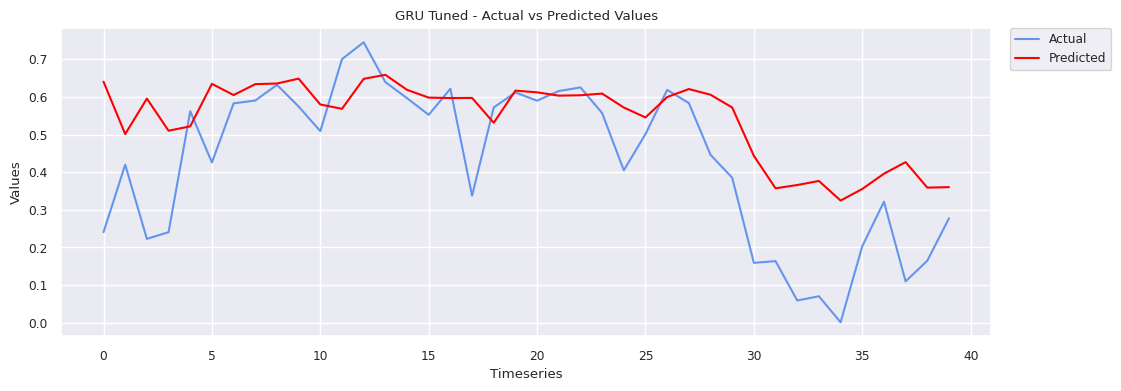

In [ ]:
#--------------------------------------------------------------------------------------#
# Predict on Holdout/Test Dataset - Tuned GRU
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
gru_tuned_preds_test = model_predict(gru_hyperband_model, test_gen, 'GRU Tuned', 'Test')

# call custom function to calculate model performance after prediction
gru_tuned_test_results = calculate_metrics(gru_tuned_preds_test, 'GRU Tuned', 'Test')

#print the resulting metrics
print(gru_tuned_test_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(gru_tuned_preds_test, 'GRU Tuned')

# Section 8 - Part2: Hyperparameter Tuning on RNN, Using HyperBand
**Let's see if we can improve it further!!!**

In [ ]:
# build RNN model for RandomSearch

K.clear_session() # clear previous model from memory
tf.keras.backend.clear_session()

timesteps2=10

def build_rnn_model(hp):
    # since predicting a timeseries value, use sequential
    model = Sequential()

    # Define hyperparameter choices for regularization
    reg_type = hp.Choice('regularizer_type', ['l1', 'l2', 'l1_l2'])
    if reg_type == 'l1':
        reg = l1(0.01)
    elif reg_type == 'l2':
        reg = l2(0.01)
    else:
        reg = l1_l2(l1=0.01, l2=0.01)

    #adding a SimpleRNN and dropout layer to avoid overfitting
    model.add(SimpleRNN(units = hp.Int('units', min_value=10, max_value=100, step=10),
                  input_shape = (timesteps2, features),
                  activation=hp.Choice('hidden_activation', values=['relu', 'tanh']),
                  kernel_regularizer=reg,
                  return_sequences=False))
    model.add(Dropout(rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.04, step=0.1))) #dropout to avoid overfitting

    # output layer
    model.add(Dense(units=1, activation=hp.Choice('output_activation', values=['relu', 'linear'])))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')

    return model

In [ ]:
# setting up the Tuner with HyperBand
rnn_tuner_hyper = Hyperband(build_rnn_model,
                     objective='val_loss',
                     max_epochs=30,
                     factor=3,
                     directory='hyper_dir_rnn1',
                     project_name='rnn_hyper_dir1')

#Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# running the search
rnn_tuner_hyper.search(train_gen, epochs=100, validation_data=(val_gen), callbacks=[stop_early])
print('Step: Running the Search Done.')

Trial 90 Complete [00h 00m 11s]
val_loss: 0.2177870273590088

Best val_loss So Far: 0.015372310765087605
Total elapsed time: 00h 06m 23s
Step: Running the Search Done.


In [ ]:
# tuner summary results
rnn_tuner_hyper.results_summary()

Results summary
Results in hyper_dir_rnn1/rnn_hyper_dir1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0073 summary
Hyperparameters:
regularizer_type: l2
units: 20
hidden_activation: relu
dropout_rate: 0.0
output_activation: relu
learning_rate: 0.01
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
Score: 0.015372310765087605

Trial 0086 summary
Hyperparameters:
regularizer_type: l2
units: 10
hidden_activation: relu
dropout_rate: 0.0
output_activation: linear
learning_rate: 0.01
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.015439115464687347

Trial 0050 summary
Hyperparameters:
regularizer_type: l2
units: 30
hidden_activation: relu
dropout_rate: 0.0
output_activation: relu
learning_rate: 0.01
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.016598690301179886

Trial 0072 summary
Hyperparameters:
regularizer_type: l2
units: 20


In [ ]:
# Get the optimal hyperparameters
rnn_best_hps=rnn_tuner_hyper.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal parameters are:\n
learning_rate: {rnn_best_hps.get('learning_rate')}
units: {rnn_best_hps.get('units')}
hidden_activation: {rnn_best_hps.get('hidden_activation')}
output_activation: {rnn_best_hps.get('output_activation')}
output_activation: {rnn_best_hps.get('output_activation')}
regularizer_type: {rnn_best_hps.get('regularizer_type')}
""")


The hyperparameter search is complete. The optimal parameters are:

learning_rate: 0.01
units: 20
hidden_activation: relu
output_activation: relu
output_activation: relu      
regularizer_type: l2



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
rnn_hyperband_model = rnn_tuner_hyper.hypermodel.build(rnn_best_hps)
rnn_hyperband_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 20)                720       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 741 (2.89 KB)
Trainable params: 741 (2.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#train model with tune hyperparameters
# Fit the Tuned RNN Model
rnn_history_hyper = rnn_hyperband_model.fit(train_gen, epochs=100, verbose=1, validation_data=val_gen)

Epoch 1/100
39/39 [==============================] - 1s 11ms/step - loss: 0.1664 - val_loss: 0.0659
Epoch 2/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0524 - val_loss: 0.0607
Epoch 3/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0398 - val_loss: 0.0401
Epoch 4/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0291 - val_loss: 0.0351
Epoch 5/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0230 - val_loss: 0.0278
Epoch 6/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0214 - val_loss: 0.0534
Epoch 7/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0240 - val_loss: 0.0229
Epoch 8/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0182
Epoch 9/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0180 - val_loss: 0.0181
Epoch 10/100
39/39 [==============================] - 0s 6ms/step - loss: 0.0215 - val_loss: 0.0240
Epoch 11

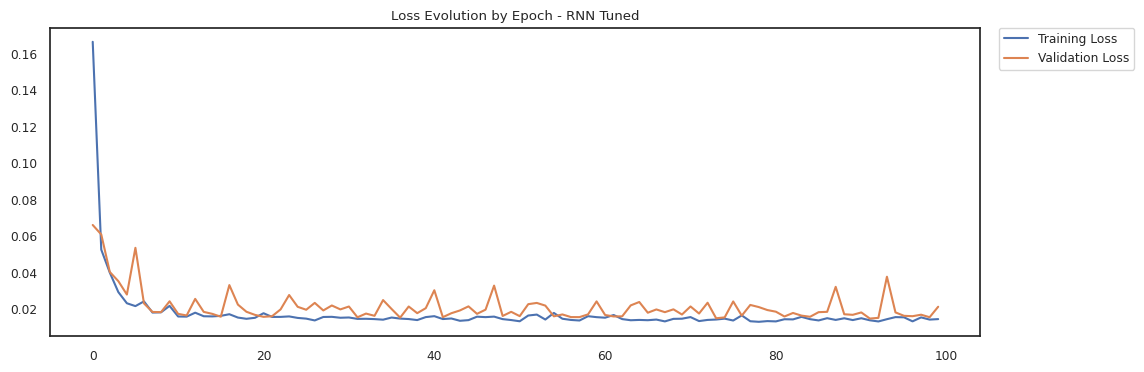

In [ ]:
# Call custom Function to evaluate loss of the trained model
plot_model_loss(rnn_history_hyper, 'RNN Tuned')

In [ ]:
#--------------------------------------------------------------------------------------#
# Evaluation vs. Prediction: model.evaluate()
#--------------------------------------------------------------------------------------#
# get model accuracy and loss
rnn_tuned_train_loss = evaluate_model_loss_mse(train_gen, rnn_hyperband_model, 'Train', 'RNN Tuned')
rnn_tuned_val_loss = evaluate_model_loss_mse(val_gen, rnn_hyperband_model,'Validation', 'RNN Tuned')
rnn_tuned_test_loss = evaluate_model_loss_mse(test_gen, rnn_hyperband_model,'Testing', 'RNN Tuned')

print('\nStep: Evaluate Loss (Mean Squared Error) complete.')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train Loss (MSE): 0.013645077124238014

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Validation Loss (MSE): 0.021062422543764114

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Testing Loss (MSE): 0.02396969310939312


Step: Evaluate Loss (Mean Squared Error) complete.


Performing Predictions on Validation Set: 

Model: RNN Tuned
Calculating Performance...

       Model       Split       MSE       MAE      RMSE        R2  Correctness
0  RNN Tuned  Validation  0.019535  0.116757  0.139769 -0.089927     84.18784


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



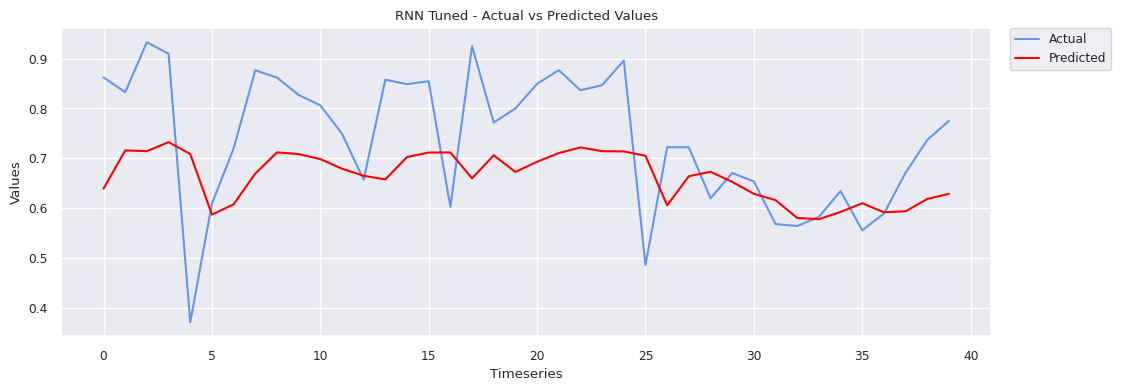

In [ ]:
#--------------------------------------------------------------------------------------#
# Predict on validation Dataset - Tuned GRU
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
rnn_tuned_preds_val = model_predict(rnn_hyperband_model, val_gen, 'RNN Tuned', 'Validation')

# call custom function to calculate model performance after prediction
rnn_tuned_val_results = calculate_metrics(rnn_tuned_preds_val, 'RNN Tuned', 'Validation')

#print the resulting metrics
print(rnn_tuned_val_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(rnn_tuned_preds_val, 'RNN Tuned')

Performing Predictions on Test Set: 

Model: RNN Tuned
Calculating Performance...

       Model Split       MSE       MAE      RMSE        R2  Correctness
0  RNN Tuned  Test  0.022443  0.111295  0.149808  0.453974     74.17868


Plotting Actuals vs Predictions (On count_scaled for review purposes)...



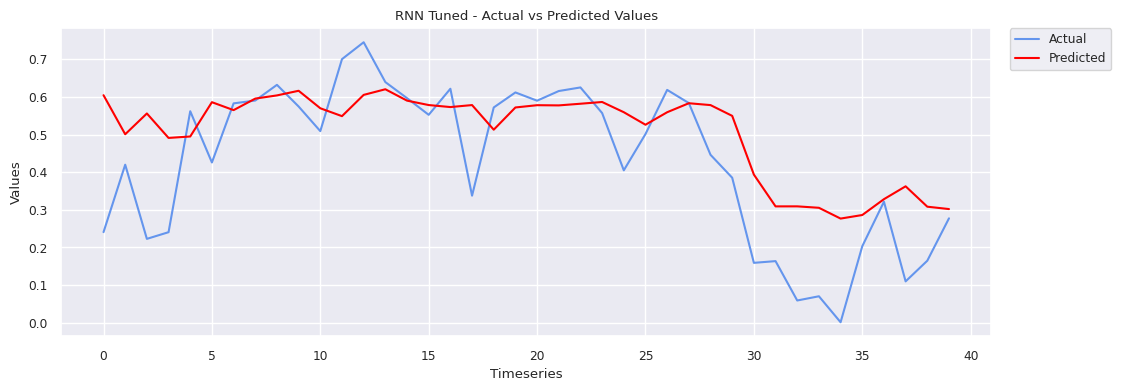

In [ ]:
#--------------------------------------------------------------------------------------#
# Predict on Test (Holdout) Dataset - Tuned GRU
#--------------------------------------------------------------------------------------#
# call custom function to predict on dataset model.predict()
rnn_tuned_preds_test = model_predict(rnn_hyperband_model, test_gen, 'RNN Tuned', 'Test')

# call custom function to calculate model performance after prediction
rnn_tuned_test_results = calculate_metrics(rnn_tuned_preds_test, 'RNN Tuned', 'Test')

#print the resulting metrics
print(rnn_tuned_test_results)

#call function to plot actuals vs predicted
plot_actual_vs_predicted(rnn_tuned_preds_test, 'RNN Tuned')

In [ ]:
#--------------------------------------------------------------------------------------#
# Merge Model Results - Validation Set
#--------------------------------------------------------------------------------------#
merged_metrics_val_df = pd.concat([rnn_v1_val_results
                               ,lstm_v1_val_results
                               ,gru_v1_val_results
                               ,gru_tuned_val_results
                               ,rnn_tuned_val_results
                               ], ignore_index=True)
merged_metrics_val_df

,Model,Split,MSE,MAE,RMSE,R2,Correctness
0,RNN Base,Validation,0.021302,0.118557,0.145953,-0.188512,83.94407
1,LSTM Base,Validation,0.049169,0.189231,0.221741,-1.743277,74.37283
2,GRU Base,Validation,0.018194,0.117943,0.134886,-0.015111,84.02725
3,GRU Tuned,Validation,0.013981,0.093547,0.118243,0.219947,87.33116
4,RNN Tuned,Validation,0.019535,0.116757,0.139769,-0.089927,84.18784


,Model,Split,MSE,MAE,RMSE,R2,Correctness
0,RNN Base,Test,0.028896,0.132027,0.169990,0.296951,69.36880
1,LSTM Base,Test,0.044132,0.169989,0.210075,-0.073718,60.56141
2,GRU Base,Test,0.034069,0.132266,0.184579,0.171091,69.31335
3,GRU Tuned,Test,0.030420,0.129753,0.174412,0.259891,69.89641
4,RNN Tuned,Test,0.022443,0.111295,0.149808,0.453974,74.17868


In [ ]:
#--------------------------------------------------------------------------------------#
# Merge Model Results
#--------------------------------------------------------------------------------------#
print('Compilation of Model Losses of Different datasets')
#del merged_losses_df
merged_losses_df = pd.concat([rnn_v1_train_loss, rnn_v1_val_loss, rnn_v1_test_loss,
                              lstm_v1_train_loss, lstm_v1_val_loss, lstm_v1_test_loss,
                              gru_v1_train_loss, gru_v1_val_loss, gru_v1_test_loss,
                              gru_tuned_train_loss, gru_tuned_val_loss, gru_tuned_test_loss,
                              rnn_tuned_train_loss, rnn_tuned_val_loss, rnn_tuned_test_loss
                              ], ignore_index=True)
merged_losses_df

Compilation of Model Losses of Different datasets


,Model,Set,Loss
0,RNN Base,Train,0.012985
1,RNN Base,Validation,0.021302
2,RNN Base,Testing,0.028896
3,LSTM Base,Train,0.012438
4,LSTM Base,Validation,0.020801
5,LSTM Base,Testing,0.058942
6,GRU Base,Train,0.010331
7,GRU Base,Validation,0.018194
8,GRU Base,Testing,0.034069
9,GRU Tuned,Train,0.013821


# Section 9: Final Performance Evaluation

In [ ]:
#--------------------------------------------------------------------------------------#
# 9.1 Display Combined Performance Metrics Dataframe
#--------------------------------------------------------------------------------------#
print('Model Performance:')
# Merge Model Results - Test (Holdout Set)
#--------------------------------------------------------------------------------------#
merged_metrics_df = pd.concat([rnn_v1_test_results
                               ,lstm_v1_test_results
                               ,gru_v1_test_results
                               ,gru_tuned_test_results
                               ,rnn_tuned_test_results
                               ], ignore_index=True)
merged_metrics_df.sort_values(by='MSE', ascending=True)

Model Performance:


,Model,Split,MSE,MAE,RMSE,R2,Correctness
4,RNN Tuned,Test,0.022443,0.111295,0.149808,0.453974,74.17868
0,RNN Base,Test,0.028896,0.132027,0.169990,0.296951,69.36880
3,GRU Tuned,Test,0.030420,0.129753,0.174412,0.259891,69.89641
2,GRU Base,Test,0.034069,0.132266,0.184579,0.171091,69.31335
1,LSTM Base,Test,0.044132,0.169989,0.210075,-0.073718,60.56141


In [ ]:
#--------------------------------------------------------------------------------------#
# 9.1 Display Combined Performance Metrics Dataframe (Validation)
#--------------------------------------------------------------------------------------#
print('Model Performance (Validation):')
#combined performance metrics results for all models
merged_metrics_val_df.sort_values(by='MSE', ascending=True)

Model Performance (Validation):


,Model,Split,MSE,MAE,RMSE,R2,Correctness
3,GRU Tuned,Validation,0.013981,0.093547,0.118243,0.219947,87.33116
2,GRU Base,Validation,0.018194,0.117943,0.134886,-0.015111,84.02725
4,RNN Tuned,Validation,0.019535,0.116757,0.139769,-0.089927,84.18784
0,RNN Base,Validation,0.021302,0.118557,0.145953,-0.188512,83.94407
1,LSTM Base,Validation,0.049169,0.189231,0.221741,-1.743277,74.37283


In [ ]:
#--------------------------------------------------------------------------------------#
# 9.2 Display Combined Losses (Train, Validation, Holdout) Dataframe
#--------------------------------------------------------------------------------------#
print('\n\nModel Losses:')
merged_losses_df #combined losses results for all models




Model Losses:


,Model,Set,Loss
0,RNN Base,Train,0.012985
1,RNN Base,Validation,0.021302
2,RNN Base,Testing,0.028896
3,LSTM Base,Train,0.012438
4,LSTM Base,Validation,0.020801
5,LSTM Base,Testing,0.058942
6,GRU Base,Train,0.010331
7,GRU Base,Validation,0.018194
8,GRU Base,Testing,0.034069
9,GRU Tuned,Train,0.013821


### **Which Models Performed best in each area?**

In [ ]:
#--------------------------------------------------------------------------------------#
# 9.3 Mean Squared Error (MSE)
#--------------------------------------------------------------------------------------#
# Get row with the LOWEST MSE
print("Model with the Lowest MSE:")
#merged_metrics_df[merged_metrics_df['MSE'] == merged_metrics_df['MSE'].nsmallest(2)]
lowest = merged_metrics_df[['Model', 'MSE']].nsmallest(1, 'MSE')
lowest.sort_values(by='MSE', ascending=True)

Model with the Lowest MSE:


,Model,MSE
4,RNN Tuned,0.022443


In [ ]:
#--------------------------------------------------------------------------------------#
# 9.3 Mean Absolute Error (MSE)
#--------------------------------------------------------------------------------------#
# Get row with the LOWEST MAE
print("Model with the Lowest MAE:")
merged_metrics_df[merged_metrics_df['MAE'] == merged_metrics_df['MAE'].min()]

Model with the Lowest MAE:


,Model,Split,MSE,MAE,RMSE,R2,Correctness
4,RNN Tuned,Test,0.022443,0.111295,0.149808,0.453974,74.17868


In [ ]:
#--------------------------------------------------------------------------------------#
# 9.3 Root Mean Squared Error (RMSE)
#--------------------------------------------------------------------------------------#
# Get row with the lowest RMSE
print("Model with the Lowest RMSE:")
merged_metrics_df[merged_metrics_df['RMSE'] == merged_metrics_df['RMSE'].min()]

Model with the Lowest RMSE:


,Model,Split,MSE,MAE,RMSE,R2,Correctness
4,RNN Tuned,Test,0.022443,0.111295,0.149808,0.453974,74.17868


In [ ]:
#--------------------------------------------------------------------------------------#
# 9.4 R-squared
#--------------------------------------------------------------------------------------#
# Get row with the highest R2
print("Model with the Highest R2:")
merged_metrics_df[merged_metrics_df['R2'] == merged_metrics_df['R2'].max()]

Model with the Highest R2:


,Model,Split,MSE,MAE,RMSE,R2,Correctness
4,RNN Tuned,Test,0.022443,0.111295,0.149808,0.453974,74.17868


In [ ]:
#--------------------------------------------------------------------------------------#
# 9.5 Correctness
#--------------------------------------------------------------------------------------#
# Get row with the highest Correctness
print("Model with the Highest Correctness:")
merged_metrics_df[merged_metrics_df['Correctness'] == merged_metrics_df['Correctness'].max()]

Model with the Highest Correctness:


,Model,Split,MSE,MAE,RMSE,R2,Correctness
4,RNN Tuned,Test,0.022443,0.111295,0.149808,0.453974,74.17868


**MSE**: is the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. MSE gives a rough idea of the magnitude of the error. It punishes larger errors more than smaller ones, due to squaring the errors.


**MAE**: is the average of the absolute differences between predicted values and actual values. It provides a linear score that reflects the magnitude of error in prediction. MAE is easier to interpret than MSE because it’s in the same units as the output variable. It’s particularly useful when you need to explain an error magnitude directly in the context of the data

**RMSE**: is the square root of the mean of the squared errors, providing a measure of the magnitude of error in the same units as the response variable. RMSE is more sensitive to outliers than MAE and can therefore be more appropriate in situations where it is crucial to avoid large errors. The RMSE will increase as the variance of the error increases.

**R-Squared:** is a relative measure of fit that indicates how much of the variability in the dependent variable can be explained by the model. An R² of 0.6 suggests that 60% of the variability in the response variable can be explained by the model’s inputs. R² values are between 0 and 1, with higher values generally indicating a better fit, although they should be interpreted in the context of the number of predictors and the noise level in the data

**Correctnes:**
correctness = 100 - ((mae/mean) * 100)

Higher Correctness: A high correctness value close to 100 indicates that the MAE is very small relative to the mean of the actual values, suggesting that the model's predictions are generally close to the actual values. This would indicate a high level of accuracy or precision in the model’s predictions.

Lower Correctness: A low correctness value indicates a large MAE relative to the mean, suggesting significant errors in the model’s predictions relative to the size of the values being predicted.

This kind of metric could be particularly useful in contexts where it's important to put the error in perspective relative to the scale of the data being modeled. For example, a $1,000 error in predicting house prices might be considered negligible in markets where houses cost millions, but significant in markets with much lower average prices.

In [ ]:
# interpolate cmap values for plots
cmap = mat.cm.Blues(np.linspace(0,1,100))
cmapblues = mat.colors.ListedColormap(cmap[30:-3])

cmap = mat.cm.Purples(np.linspace(0,1,100))
cmappurples = mat.colors.ListedColormap(cmap[30:-3])

cmap = mat.cm.Greens(np.linspace(0,1,100))
cmapgreens = mat.colors.ListedColormap(cmap[30:-3])

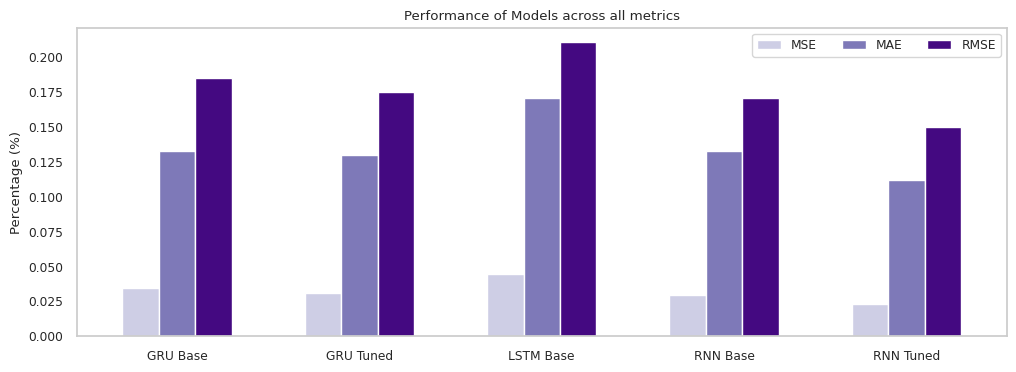

In [ ]:
#--------------------------------------------------------------------------------------#
#9.6 Visualize: Comparison of Model Performances
#--------------------------------------------------------------------------------------#
# plot a graph to compare metrics visually
sns.set_style("whitegrid")
eval_metrics = merged_metrics_df[['Model', 'MSE', 'MAE', 'RMSE']].copy()
eval_metrics.sort_values(by="Model", ascending=True, inplace=True)
#eval_metrics.reset_index(drop=True, inplace=True

metrics_plot = eval_metrics.plot.bar(cmap = cmappurples,
                figsize=(12, 4),
                width = 0.6,
                grid=False)
metrics_plot.set_xticklabels(eval_metrics['Model'])

plt.xticks(rotation=0)
#plt.yticks(np.arange(0,101, 10))        #calculate a range of numbers from 0, 100 with a step 10
plt.ylabel("Percentage (%)")
#plt.xlabel("Regressors", y=1.02)
#plt.xlabel("Model-Vectorizer Performance")
plt.legend(loc='best', ncols=3)
plt.title(f'Performance of Models')
plt.show()

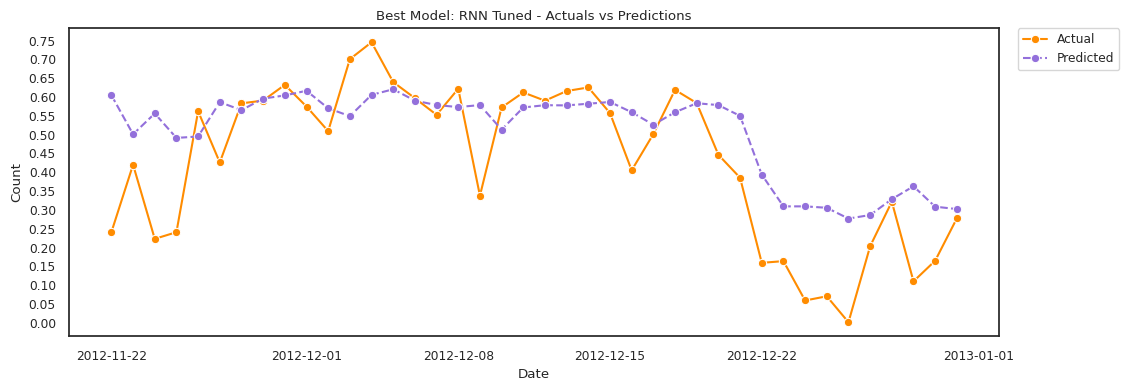

In [ ]:
#--------------------------------------------------------------------------------------#
#9.7 Visualize: Plot Best Model - Actuals vs Predictions
#--------------------------------------------------------------------------------------#
# Extract the last 40 dates (indexes)
last_40_dates = test_df.index[-40:]

# Flatten the dates
flattened_dates = last_40_dates.to_numpy()

#print the resulting metrics
best_model_predictions = rnn_tuned_preds_test.copy()
best_model_predictions.index = flattened_dates
best_model_predictions.head()

# Plot the counts
sns.set_style("white")
# Set the figure size
plt.figure(figsize=(12, 4))
sns.lineplot(data=best_model_predictions, x=best_model_predictions.index, y='Actual'
            , color='darkorange', label='Actual', linestyle='solid', marker='o')
sns.lineplot(data=best_model_predictions, x=best_model_predictions.index, y='Predicted'
            , color='mediumpurple',label='Predicted', linestyle='dashed', marker='o')

# Add a title and labels
plt.title("Best Model: RNN Tuned - Actuals vs Predictions")
plt.xlabel('Date')
plt.ylabel("Count")
plt.yticks(np.arange(0,0.8,0.05))
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()